In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import re

from ydata_profiling import ProfileReport

import sys

sys.path.append('../src')
from utils import getExperimentConfig, translate_model_name

# Get global experiment settings
config = getExperimentConfig()
folders = config['folders']

In [2]:
#model_performance_file = folders['model_perf_filepath']
#pf_file = folders['pf_measures_filepath']

model_performance_file = "../data/result/model_performance_backup-2023-05-12.csv"
pf_file = "../data/result/pf_measures_backup-2023-05-12.csv"

pd.set_option('display.max_columns', None)

# Model Performance data cleaning
Just cleaning up the data, summerizing and restructuring it.

In [3]:
models_df = pd.read_csv(model_performance_file)
models_df

,Dataset id,model,F1,Accuracy,AUC,MCC,Kappa,Params,Tuned on,Trained on,USI,Quality,SDG,Accuracy_same,F1_same,MCC_same,Kappa_same,Accuracy_strat,F1_strat,MCC_strat,Kappa_strat
0,D0,lr,0.713636,0.766234,NaN,0.461883,0.438866,"{'C': 11.288378916846883, 'class_weight': None...",original,original,4d68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D0,knn,0.678394,0.746753,NaN,0.411811,0.377617,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",original,original,4d68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,D0,rbfsvm,0.688988,0.753247,NaN,0.428830,0.396452,"{'C': 0.23357214690901212, 'break_ties': False...",original,original,4d68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D0,rf,0.727594,0.766234,NaN,0.466667,0.459016,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",original,original,4d68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,D1,lr,1.000000,1.000000,NaN,1.000000,1.000000,"{'C': 1.0, 'class_weight': None, 'dual': False...",original,original,6a86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,SD305Q3_9,rbfsvm,NaN,NaN,NaN,NaN,NaN,"{'C': 4.281332398719396, 'break_ties': False, ...",original,synthetic,dae3,Q3,SD305Q3,0.297143,0.280015,0.219530,0.218695,0.098571,0.094676,-0.002047,-0.002039
812,SD305Q3_9,lr,NaN,NaN,NaN,NaN,NaN,"{'C': 545.5594781168514, 'class_weight': None,...",synthetic,synthetic,dae3,Q3,SD305Q3,0.201429,0.198493,0.113110,0.112904,0.087143,0.086684,-0.014077,-0.014051
813,SD305Q3_9,knn,NaN,NaN,NaN,NaN,NaN,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",synthetic,synthetic,dae3,Q3,SD305Q3,0.235714,0.216295,0.152792,0.148027,0.107143,0.093751,0.004856,0.004705
814,SD305Q3_9,rbfsvm,NaN,NaN,NaN,NaN,NaN,"{'C': 206.913808111479, 'break_ties': False, '...",synthetic,synthetic,dae3,Q3,SD305Q3,0.282857,0.278094,0.203836,0.202954,0.100000,0.097009,-0.000278,-0.000277


In [4]:
#raw_runs_df['Name'].unique()

# The columns of data that will be used to analyze the results
cols_to_keep = [
    'Dataset id',
    'model',
    'Accuracy',
    'Accuracy_same',
    'Accuracy_strat',
    'F1',
    'F1_same',
    'F1_strat',
    'Kappa',
    'Kappa_same',
    'Kappa_strat',
    'MCC',
    'MCC_same',
    'MCC_strat',
#    'AUC',
    'Tuned on',
    'Trained on',
    'SDG',
    'Quality'
]


models_filtered = models_df[cols_to_keep]


models_filtered

,Dataset id,model,Accuracy,Accuracy_same,Accuracy_strat,F1,F1_same,F1_strat,Kappa,Kappa_same,Kappa_strat,MCC,MCC_same,MCC_strat,Tuned on,Trained on,SDG,Quality
0,D0,lr,0.766234,NaN,NaN,0.713636,NaN,NaN,0.438866,NaN,NaN,0.461883,NaN,NaN,original,original,NaN,NaN
1,D0,knn,0.746753,NaN,NaN,0.678394,NaN,NaN,0.377617,NaN,NaN,0.411811,NaN,NaN,original,original,NaN,NaN
2,D0,rbfsvm,0.753247,NaN,NaN,0.688988,NaN,NaN,0.396452,NaN,NaN,0.428830,NaN,NaN,original,original,NaN,NaN
3,D0,rf,0.766234,NaN,NaN,0.727594,NaN,NaN,0.459016,NaN,NaN,0.466667,NaN,NaN,original,original,NaN,NaN
4,D1,lr,1.000000,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN,NaN,original,original,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,SD305Q3_9,rbfsvm,NaN,0.297143,0.098571,NaN,0.280015,0.094676,NaN,0.218695,-0.002039,NaN,0.219530,-0.002047,original,synthetic,SD305Q3,Q3
812,SD305Q3_9,lr,NaN,0.201429,0.087143,NaN,0.198493,0.086684,NaN,0.112904,-0.014051,NaN,0.113110,-0.014077,synthetic,synthetic,SD305Q3,Q3
813,SD305Q3_9,knn,NaN,0.235714,0.107143,NaN,0.216295,0.093751,NaN,0.148027,0.004705,NaN,0.152792,0.004856,synthetic,synthetic,SD305Q3,Q3
814,SD305Q3_9,rbfsvm,NaN,0.282857,0.100000,NaN,0.278094,0.097009,NaN,0.202954,-0.000277,NaN,0.203836,-0.000278,synthetic,synthetic,SD305Q3,Q3


Separate the performances, original models from synthetic

In [5]:
# get performance for the original models
o_perf_df = models_filtered[models_filtered['Accuracy_same'].isna() & models_filtered['Accuracy_strat'].isna()]
o_perf_df = o_perf_df.dropna(axis=1)
o_perf_df = o_perf_df.rename(columns={'Accuracy': 'Accuracy_original', 'F1': 'F1_original','Kappa': 'Kappa_original','MCC':'MCC_original'})

# get performance of the synthetic models
s_perf_df = models_filtered[models_filtered['Accuracy'].isna() & models_filtered['F1'].isna()]

Group synthetic performance by "SDG", "model", "Trained on" and "Tuned on" to get the mean of all iterations with same settings.

In [6]:
# Group by the starting substring and calculate the mean of specified columns
mean_columns = [ 'F1_same', 'F1_strat',
                 'Kappa_same','Kappa_strat', 
                 'Accuracy_same', 'Accuracy_strat', 
                 'MCC_same', 'MCC_strat']


s_perf_df = s_perf_df.groupby(['SDG', 'model', 'Trained on', 'Tuned on'])[mean_columns].mean()

# Reset index to convert indices to columns
s_perf_df = s_perf_df.reset_index()

s_perf_df

,SDG,model,Trained on,Tuned on,F1_same,F1_strat,Kappa_same,Kappa_strat,Accuracy_same,Accuracy_strat,MCC_same,MCC_strat
0,SD0Q0,knn,synthetic,synthetic,0.411049,0.399214,0.011610,-0.010842,0.522727,0.511039,0.009966,-0.015352
1,SD0Q0,lr,synthetic,original,0.369979,0.376141,-0.002690,0.004405,0.470779,0.478571,-0.009283,0.014997
2,SD0Q0,lr,synthetic,synthetic,0.356151,0.362855,-0.006385,0.003743,0.457143,0.466234,-0.007334,0.010269
3,SD0Q0,rbfsvm,synthetic,synthetic,0.390666,0.396109,-0.001576,0.009121,0.589610,0.600000,0.042356,0.021903
4,SD0Q0,rf,synthetic,synthetic,0.429841,0.447568,0.001760,0.038821,0.566883,0.586364,0.039778,0.055229
...,...,...,...,...,...,...,...,...,...,...,...,...
75,SD305Q3,knn,synthetic,synthetic,0.266265,0.090871,0.212981,0.002232,0.293143,0.103857,0.219931,0.002310
76,SD305Q3,lr,synthetic,synthetic,0.317351,0.093131,0.246961,-0.005374,0.322857,0.096000,0.247892,-0.005395
77,SD305Q3,rbfsvm,synthetic,original,0.327338,0.093542,0.261444,-0.004443,0.335714,0.096571,0.263203,-0.004473
78,SD305Q3,rbfsvm,synthetic,synthetic,0.367036,0.093531,0.306167,-0.003693,0.376143,0.097571,0.309085,-0.003728


In [7]:
def extract_dataset_id(sdg):
    match = re.match(r'SD(\d+)Q\d+', sdg)
    if match:
        return f'D{match.group(1)}'
    else:
        return None
    
def extract_quality(sdg):
    match = re.match(r'SD\d+Q(\d+)', sdg)
    if match:
        return f'Q{match.group(1)}'
    else:
        return None
    
# add column with the original dataset
s_perf_df['original_id'] = s_perf_df['SDG'].apply(extract_dataset_id)

# add column with the quality
s_perf_df['quality'] = s_perf_df['SDG'].apply(extract_quality)

s_perf_df

,SDG,model,Trained on,Tuned on,F1_same,F1_strat,Kappa_same,Kappa_strat,Accuracy_same,Accuracy_strat,MCC_same,MCC_strat,original_id,quality
0,SD0Q0,knn,synthetic,synthetic,0.411049,0.399214,0.011610,-0.010842,0.522727,0.511039,0.009966,-0.015352,D0,Q0
1,SD0Q0,lr,synthetic,original,0.369979,0.376141,-0.002690,0.004405,0.470779,0.478571,-0.009283,0.014997,D0,Q0
2,SD0Q0,lr,synthetic,synthetic,0.356151,0.362855,-0.006385,0.003743,0.457143,0.466234,-0.007334,0.010269,D0,Q0
3,SD0Q0,rbfsvm,synthetic,synthetic,0.390666,0.396109,-0.001576,0.009121,0.589610,0.600000,0.042356,0.021903,D0,Q0
4,SD0Q0,rf,synthetic,synthetic,0.429841,0.447568,0.001760,0.038821,0.566883,0.586364,0.039778,0.055229,D0,Q0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,SD305Q3,knn,synthetic,synthetic,0.266265,0.090871,0.212981,0.002232,0.293143,0.103857,0.219931,0.002310,D305,Q3
76,SD305Q3,lr,synthetic,synthetic,0.317351,0.093131,0.246961,-0.005374,0.322857,0.096000,0.247892,-0.005395,D305,Q3
77,SD305Q3,rbfsvm,synthetic,original,0.327338,0.093542,0.261444,-0.004443,0.335714,0.096571,0.263203,-0.004473,D305,Q3
78,SD305Q3,rbfsvm,synthetic,synthetic,0.367036,0.093531,0.306167,-0.003693,0.376143,0.097571,0.309085,-0.003728,D305,Q3


Merge the datasets o_perf_df with s_perf_df and create columns for the difference in performance.

synthetic performance - original performance

In [85]:
display(s_perf_df['original_id'].unique())
display(o_perf_df['Dataset id'].unique())


array(['D0', 'D1', 'D205', 'D305'], dtype=object)

array(['D0', 'D1', 'D305', 'D205'], dtype=object)

KeyError: Index(['model_o', 'Trained on_o', 'Tuned on_o'], dtype='object')

In [8]:
# Merge DataFrames with suffixes
perf_df = o_perf_df.merge(s_perf_df, left_on='Dataset id', right_on='original_id', suffixes=('_o', '_s'))

# Drop duplicate columns (use the columns from the original DataFrame)
columns_to_drop = ['Dataset id','model_o', 'Tuned on_o', 'Trained on_o']
perf_df=perf_df.drop(columns_to_drop, axis=1)

# Rename columns to remove the '_o' suffix
perf_df=perf_df.rename(columns=lambda x: x.rstrip('_s'))
perf_df = perf_df.drop('Trained on', axis=1)

perf_df['Accuracy_diff_same'] =  perf_df['Accuracy_original'] - perf_df['Accuracy_same'] 
perf_df['Accuracy_diff_strat'] = perf_df['Accuracy_original'] - perf_df['Accuracy_strat'] 

perf_df['F1_diff_same'] =  perf_df['F1_original'] - perf_df['F1_same'] 
perf_df['F1_diff_strat'] = perf_df['F1_original'] - perf_df['F1_strat'] 

perf_df['MCC_diff_same'] =  perf_df['MCC_original'] - perf_df['MCC_same'] 
perf_df['MCC_diff_strat'] = perf_df['MCC_original'] - perf_df['MCC_strat']

perf_df['Kappa_diff_same'] =  perf_df['Kappa_original'] - perf_df['Kappa_same'] 
perf_df['Kappa_diff_strat'] = perf_df['Kappa_original'] - perf_df['Kappa_strat'] 

perf_df['model'] = perf_df['model'].replace('rbfsvm', 'svm')
perf_df.loc[perf_df['Tuned on'] == 'original', 'model'] = 'o_' + perf_df.loc[perf_df['Tuned on'] == 'original', 'model']

display(perf_df)

,Accuracy_original,F1_original,Kappa_original,MCC_original,SDG,model,Tuned on,F1_same,F1_strat,Kappa_same,Kappa_strat,Accuracy_same,Accuracy_strat,MCC_same,MCC_strat,original_id,quality,Accuracy_diff_same,Accuracy_diff_strat,F1_diff_same,F1_diff_strat,MCC_diff_same,MCC_diff_strat,Kappa_diff_same,Kappa_diff_strat
0,0.766234,0.713636,0.438866,0.461883,SD0Q0,knn,synthetic,0.411049,0.399214,0.011610,-0.010842,0.522727,0.511039,0.009966,-0.015352,D0,Q0,0.243506,0.255195,0.302588,0.314422,0.451917,0.477235,0.427256,0.449709
1,0.766234,0.713636,0.438866,0.461883,SD0Q0,o_lr,original,0.369979,0.376141,-0.002690,0.004405,0.470779,0.478571,-0.009283,0.014997,D0,Q0,0.295455,0.287662,0.343658,0.337496,0.471167,0.446887,0.441557,0.434461
2,0.766234,0.713636,0.438866,0.461883,SD0Q0,lr,synthetic,0.356151,0.362855,-0.006385,0.003743,0.457143,0.466234,-0.007334,0.010269,D0,Q0,0.309091,0.300000,0.357485,0.350781,0.469217,0.451614,0.445251,0.435124
3,0.766234,0.713636,0.438866,0.461883,SD0Q0,svm,synthetic,0.390666,0.396109,-0.001576,0.009121,0.589610,0.600000,0.042356,0.021903,D0,Q0,0.176623,0.166234,0.322970,0.317528,0.419527,0.439981,0.440442,0.429746
4,0.766234,0.713636,0.438866,0.461883,SD0Q0,rf,synthetic,0.429841,0.447568,0.001760,0.038821,0.566883,0.586364,0.039778,0.055229,D0,Q0,0.199351,0.179870,0.283795,0.266068,0.422105,0.406654,0.437107,0.400045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,0.889381,0.632042,0.276151,0.311606,SD205Q3,knn,synthetic,0.547657,0.465648,0.130522,-0.027412,0.886726,0.865929,0.201832,-0.042972,D205,Q3,0.002655,0.023451,0.084385,0.166394,0.109773,0.354577,0.145629,0.303563
316,0.889381,0.632042,0.276151,0.311606,SD205Q3,o_lr,original,0.570156,0.461709,0.167391,-0.042799,0.886504,0.857743,0.227913,-0.058114,D205,Q3,0.002876,0.031637,0.061885,0.170333,0.083692,0.369720,0.108761,0.318951
317,0.889381,0.632042,0.276151,0.311606,SD205Q3,lr,synthetic,0.569697,0.462031,0.167213,-0.041249,0.887168,0.858850,0.230606,-0.056888,D205,Q3,0.002212,0.030531,0.062344,0.170010,0.080999,0.368494,0.108938,0.317400
318,0.889381,0.632042,0.276151,0.311606,SD205Q3,svm,synthetic,0.564706,0.462605,0.159242,-0.038111,0.887389,0.860841,0.228386,-0.054166,D205,Q3,0.001991,0.028540,0.067336,0.169437,0.083220,0.365772,0.116909,0.314263


# Difference in performance for each Dataset

The difference meaning: *Synthetic performance metric - Original performance metric*

**(same)**: means the models were tested on the same subset of samples   
**(strat)** means the models were tested on different subset of samples, extracted through stratified sampling method.  
**model names**:  
  - lr: Logistic Regression
  - knn: K-Nearest Neighbor
  - svm: Support Vector Machines
  - o_: means the hyperparameter tuning was done on the original data

## Performance difference: Accuracy

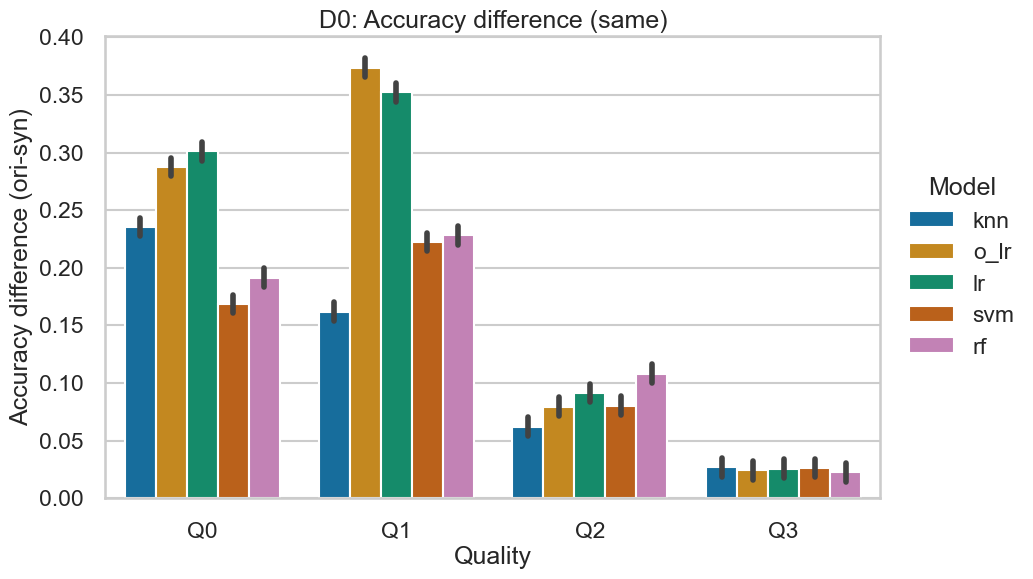

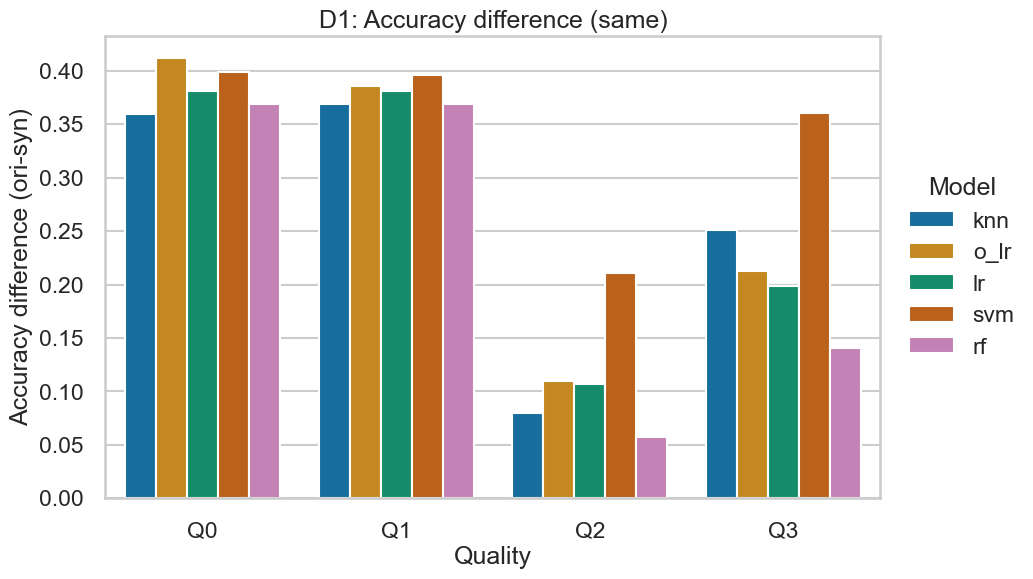

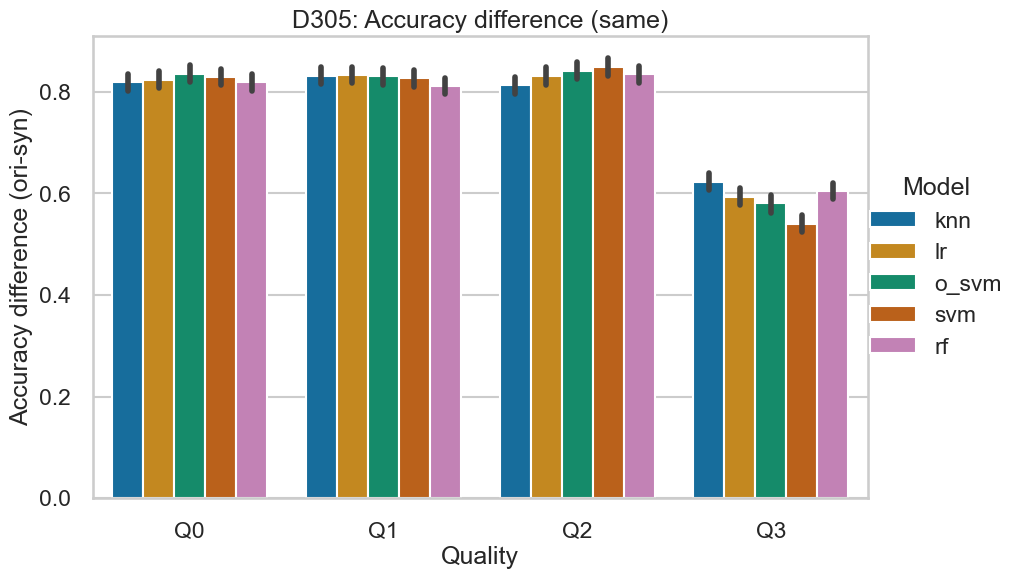

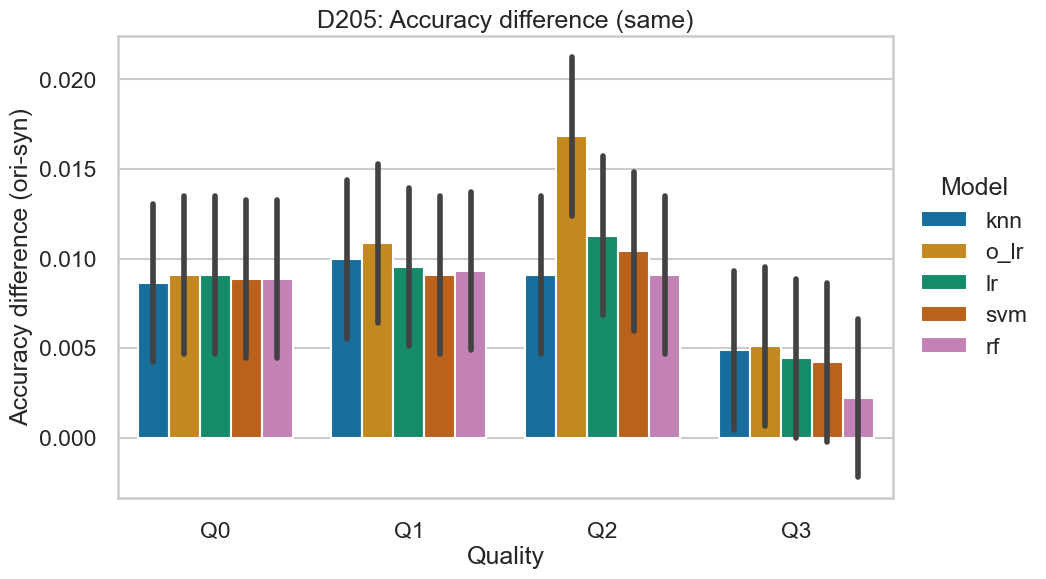

In [9]:
sns.set_style(style="whitegrid")
sns.set_context('talk')
sns.set_palette('colorblind')

dataset_ids = perf_df['original_id'].unique()
metric = 'Accuracy'
metric_type = 'same'
col_metric = f"{metric}_diff_{metric_type}"

for data_id in dataset_ids:

    filtered_data = perf_df[perf_df['original_id'] == data_id]

    plt.figure(figsize=(10, 6))
    sns.barplot(x='quality', y=col_metric, hue='model', data=filtered_data)
    plt.title(f"{data_id}: {metric} difference ({metric_type})")
    plt.ylabel(f"{metric} difference (ori-syn)")
    plt.xlabel("Quality")
    plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), title="Model")
    plt.show()

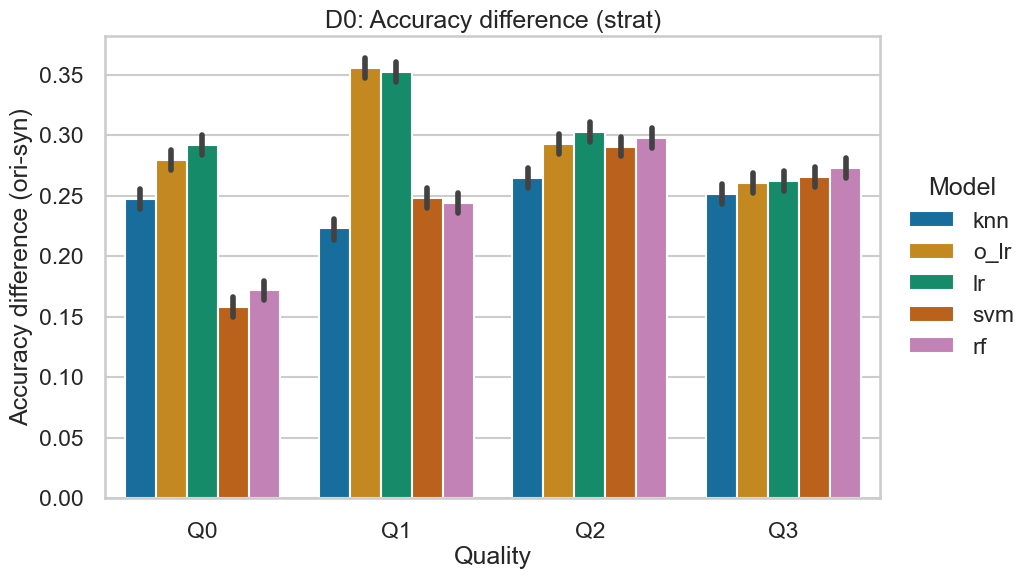

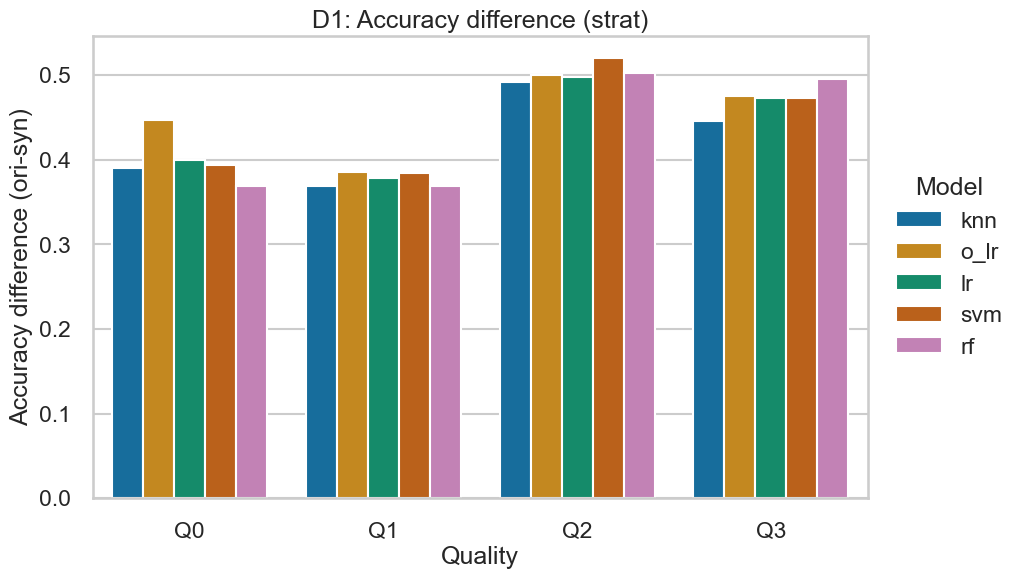

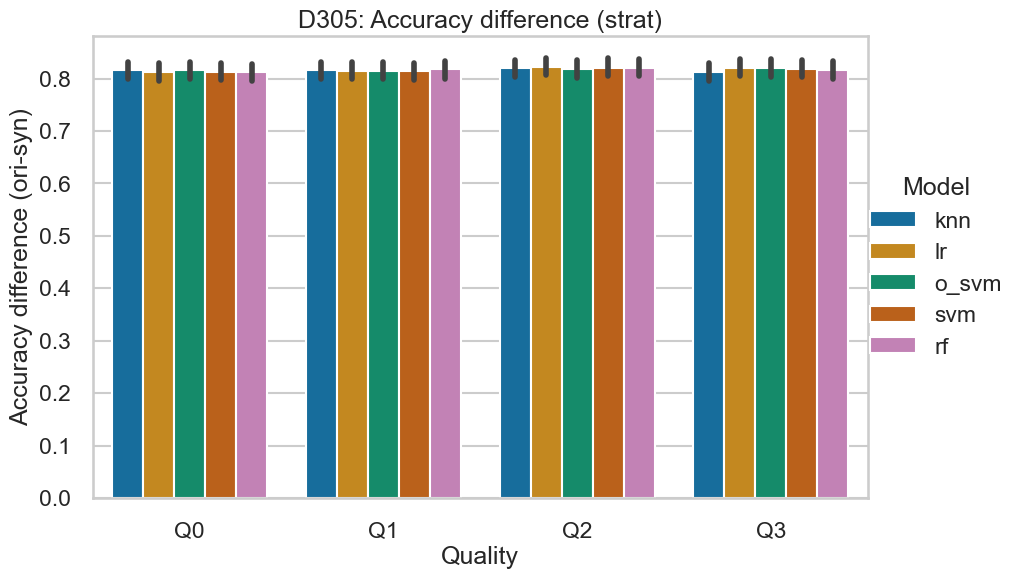

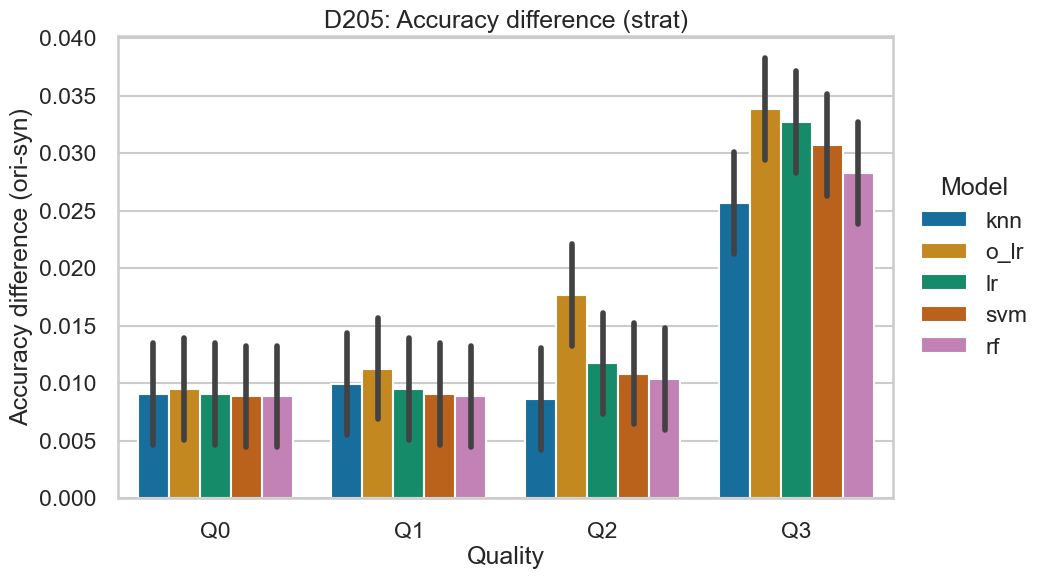

In [10]:
dataset_ids = perf_df['original_id'].unique()
metric = 'Accuracy'
metric_type = 'strat'
col_metric = f"{metric}_diff_{metric_type}"

for data_id in dataset_ids:

    filtered_data = perf_df[perf_df['original_id'] == data_id]

    plt.figure(figsize=(10, 6))
    sns.barplot(x='quality', y=col_metric, hue='model', data=filtered_data)
    plt.title(f"{data_id}: {metric} difference ({metric_type})")
    plt.ylabel(f"{metric} difference (ori-syn)")
    plt.xlabel("Quality")
    plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), title="Model")
    plt.show()

## Difference in performance: F1

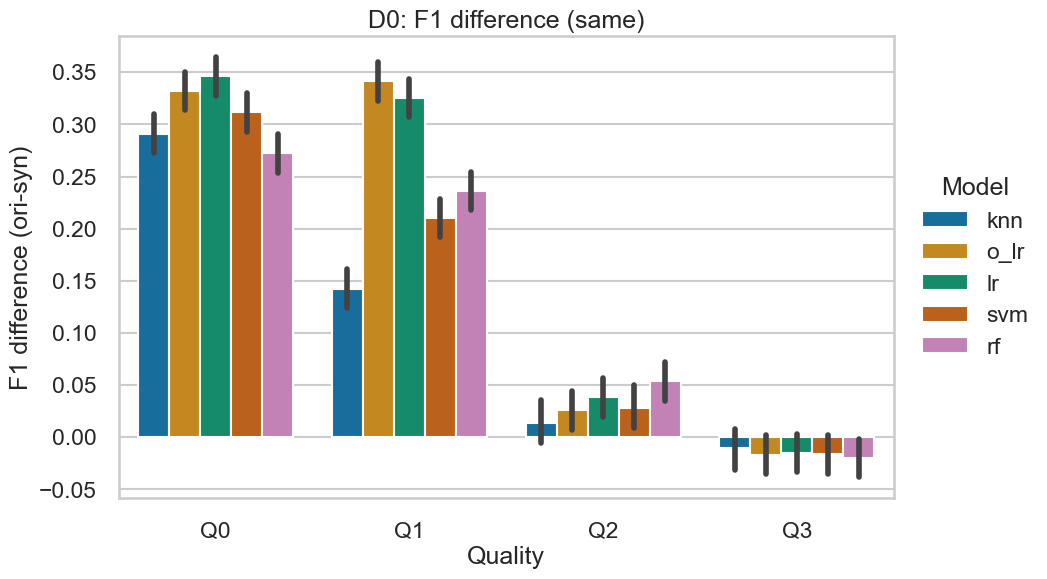

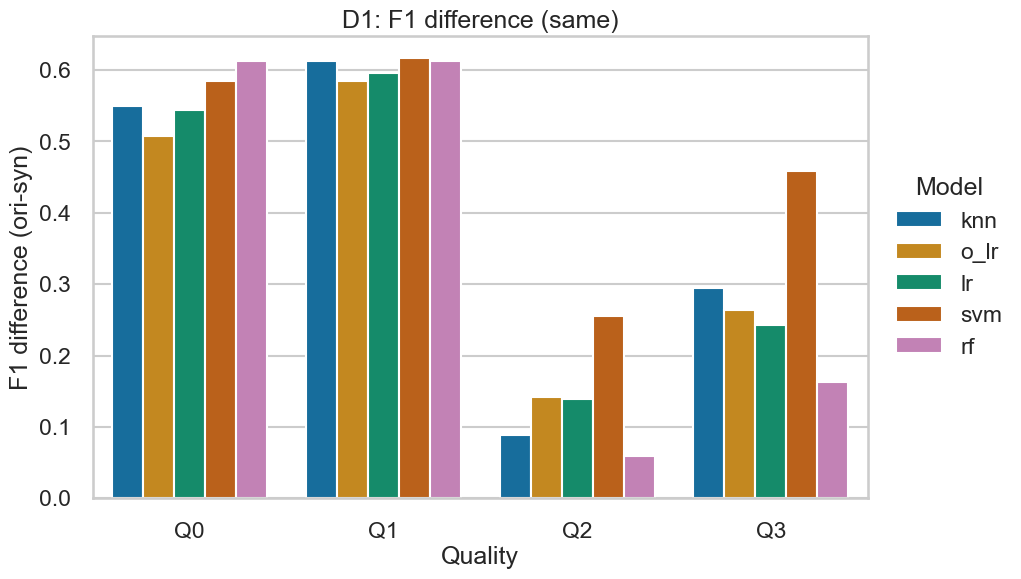

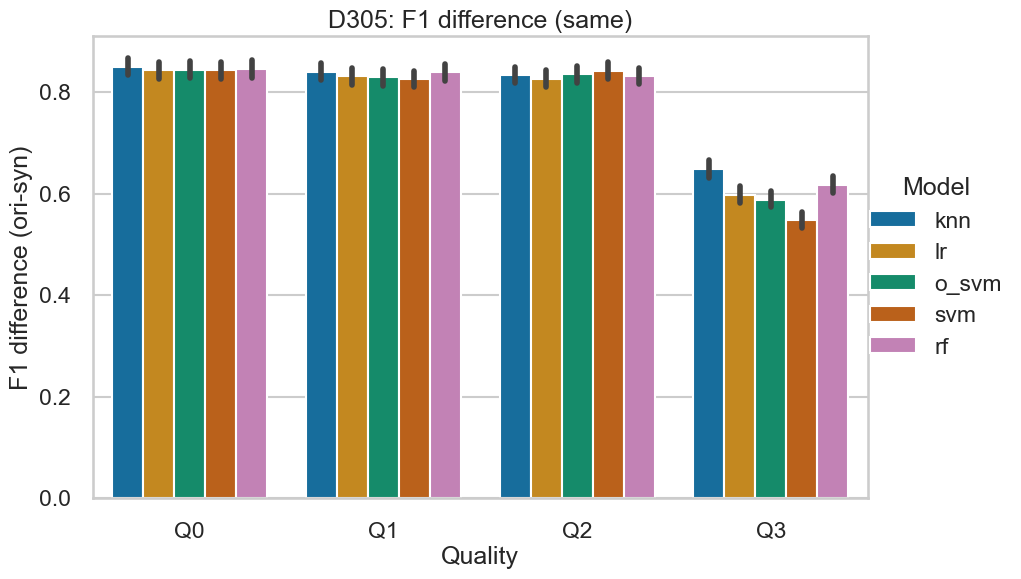

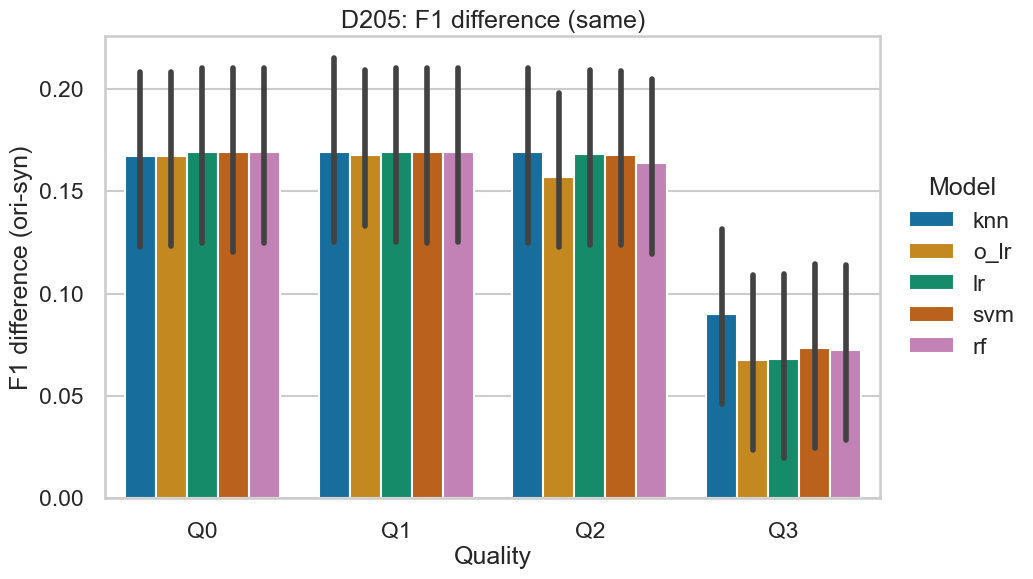

In [11]:
dataset_ids = perf_df['original_id'].unique()
metric = 'F1'
metric_type = 'same'
col_metric = f"{metric}_diff_{metric_type}"

for data_id in dataset_ids:

    filtered_data = perf_df[perf_df['original_id'] == data_id]

    plt.figure(figsize=(10, 6))
    sns.barplot(x='quality', y=col_metric, hue='model', data=filtered_data)
    plt.title(f"{data_id}: {metric} difference ({metric_type})")
    plt.ylabel(f"{metric} difference (ori-syn)")
    plt.xlabel("Quality")
    plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), title="Model")
    plt.show()

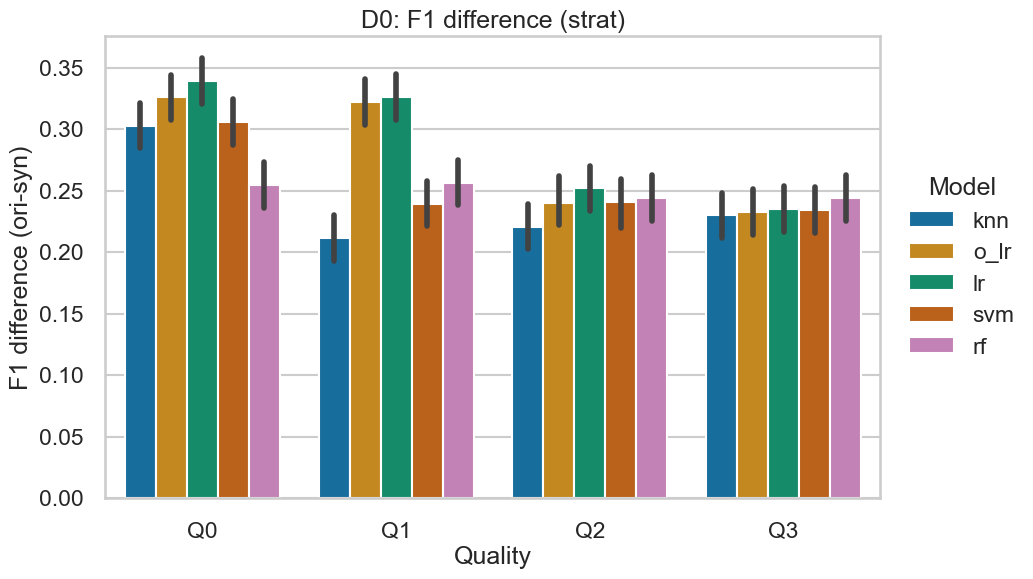

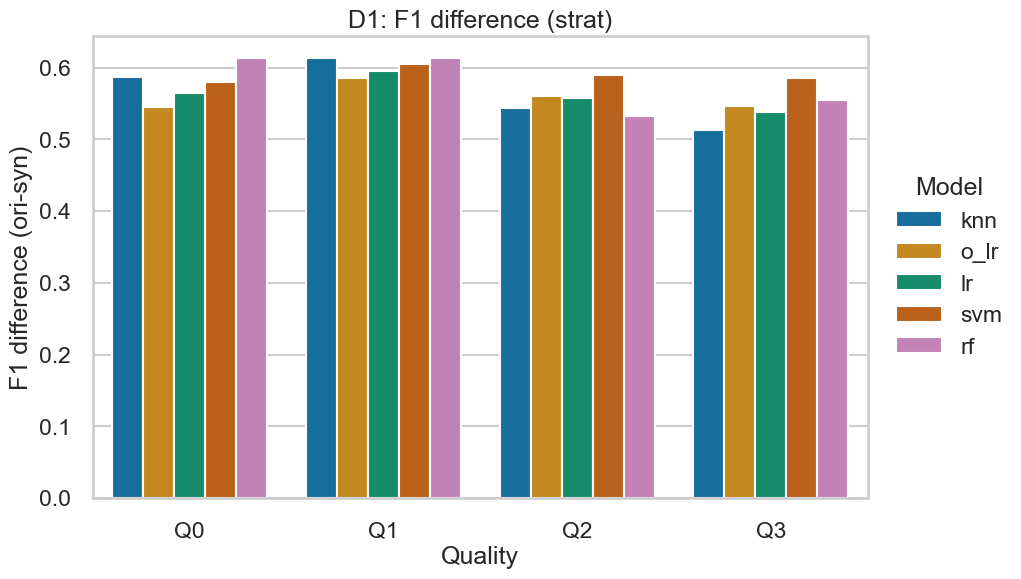

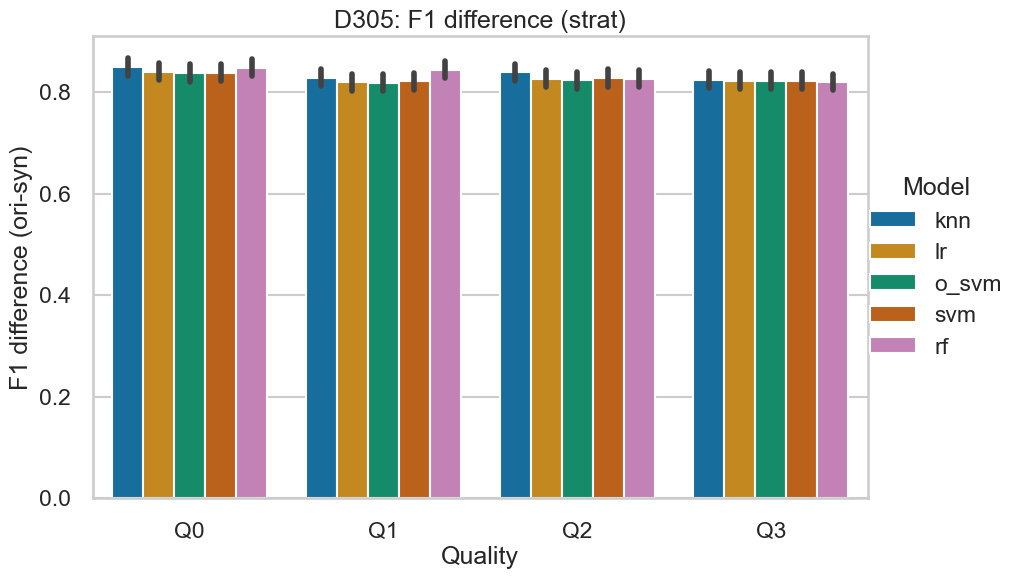

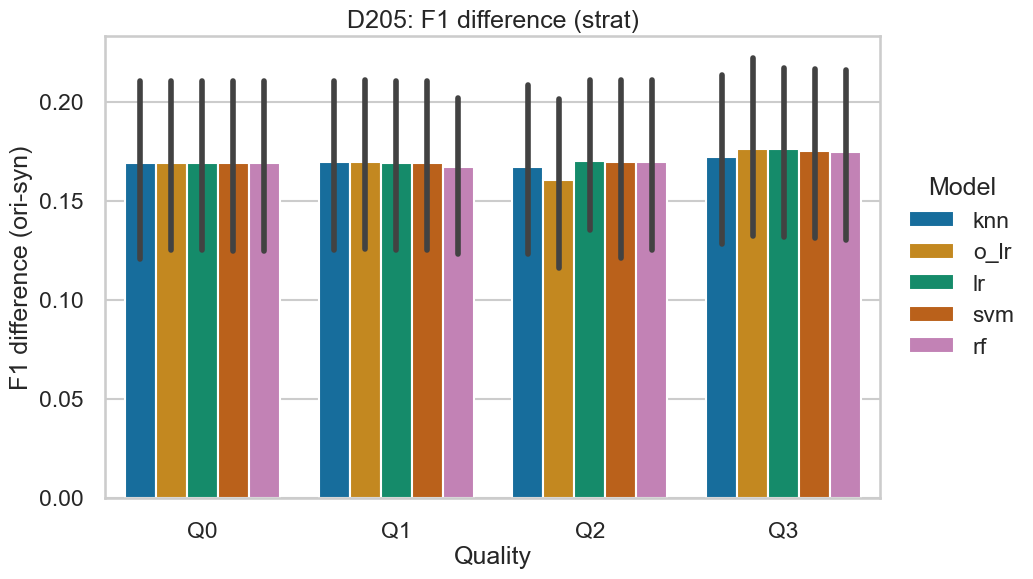

In [12]:
dataset_ids = perf_df['original_id'].unique()
metric = 'F1'
metric_type = 'strat'
col_metric = f"{metric}_diff_{metric_type}"

for data_id in dataset_ids:

    filtered_data = perf_df[perf_df['original_id'] == data_id]

    plt.figure(figsize=(10, 6))
    sns.barplot(x='quality', y=col_metric, hue='model', data=filtered_data)
    plt.title(f"{data_id}: {metric} difference ({metric_type})")
    plt.ylabel(f"{metric} difference (ori-syn)")
    plt.xlabel("Quality")
    plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), title="Model")
    plt.show()

## MNIST images

In [14]:
mnist_real_df = pd.read_csv('../data/real/D305-mnist.csv')
mnist_q0_df = pd.read_csv('../data/synthetic/SD305Q1_0.csv')
mnist_q1_df = pd.read_csv('../data/synthetic/SD305Q10_1.csv')
mnist_q2_df = pd.read_csv('../data/synthetic/SD305Q100_2.csv')

In [16]:
# Group the data by label and extract one random sample from each group
samples_real = mnist_real_df.groupby("label").sample(n=1)
samples_q0 = mnist_q0_df.groupby("label").apply(lambda x: x.sample(n=1))
samples_q1 = mnist_q1_df.groupby("label").apply(lambda x: x.sample(n=1))
samples_q2 = mnist_q2_df.groupby("label").apply(lambda x: x.sample(n=1))

samples_dict = {"Real": samples_real, "Q0": samples_q0, "Q1": samples_q1, "Q2": samples_q2}

SDG-Quality: Real


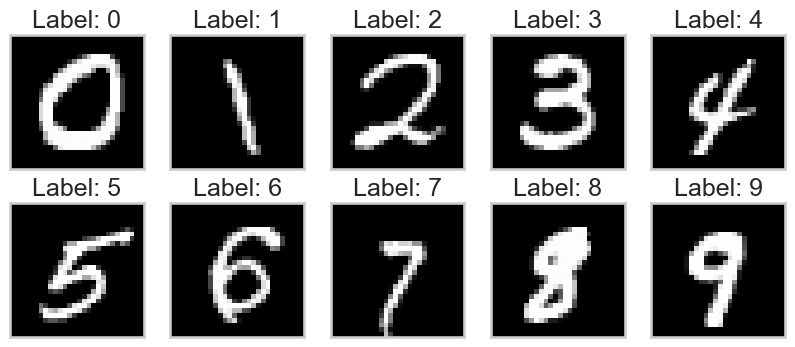

SDG-Quality: Q0


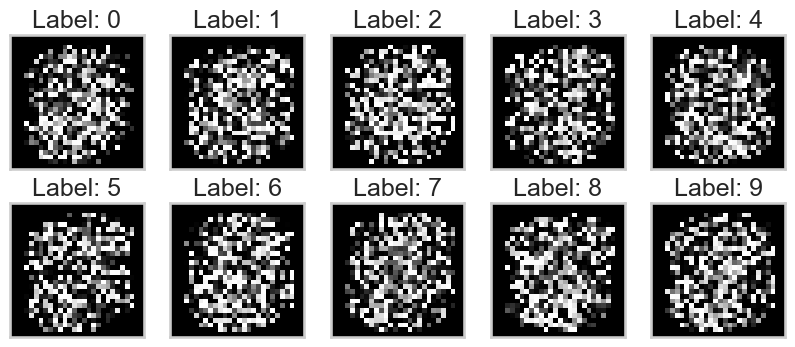

SDG-Quality: Q1


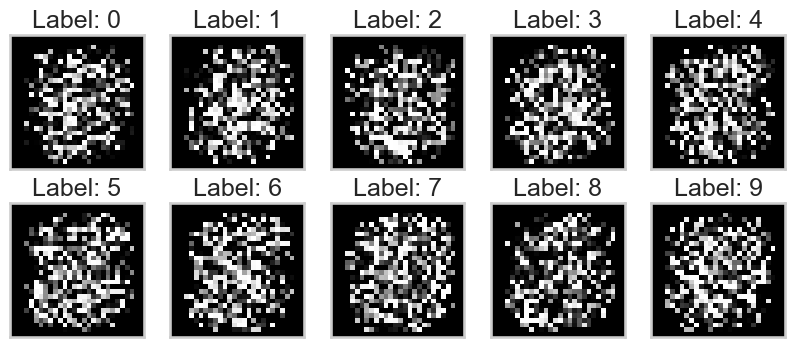

SDG-Quality: Q2


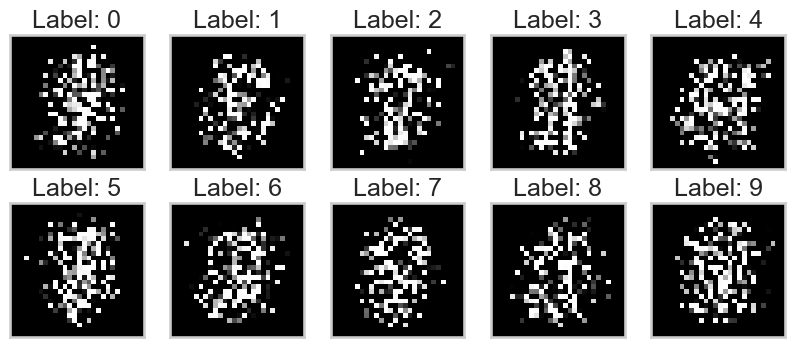

In [17]:
images = samples_real
for quality in samples_dict:
    print(f"SDG-Quality: {quality}")
    images = samples_dict[quality]
    # Display the images in a 2x5 grid
    fig, axes = plt.subplots(2, 5, figsize=(10,4))
    for i, ax in enumerate(axes.flat):
        label = images.iloc[i][0]
        img = images.iloc[i][1:]
        pixles = np.array(img).reshape(28,28)

        ax.imshow(pixles, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Label: {label}")
    plt.show()
    print("===============")


# PF measures analysis

In [18]:
pf = pd.read_csv(pf_file)

# add column with the original dataset
pf['original_id'] = pf['SDG'].apply(extract_dataset_id)

# add column with the quality
pf['quality'] = pf['SDG'].apply(extract_quality)
display(pf)
display(pf['quality'].unique())

,DatasetName,SDG,pMSE,pMSE_time,s_pMSE,s_pMSE_time,Cluster_G_0.5,Cluster_G_0.5_time,Cluster_G_1,Cluster_G_1_time,Cluster_G_1.5,Cluster_G_1.5_time,Cluster_G_2,Cluster_G_2_time,Cluster_G_2.5,Cluster_G_2.5_time,BNLogLikelihood,BNLogLikelihood_time,GMLogLikelihood,GMLogLikelihood_time,ContinousKLDivergence,ContinousKLDivergence_time,DiscreteKLDivergence,DiscreteKLDivergence_time,KSComplement,KSComplement_time,CSTest,CSTest_time,CrCl,CrCl_time,Quality,Original dataset,original_id,quality
0,SD0Q2_0,SD0Q2,0.026934,0.141130,15.387917,0.155214,1.257674,24.953988,0.831537,28.370561,1.161917,33.701431,1.177334,37.804962,1.020096,43.795048,-7.580443e-01,0.400678,-30.168042,1.532983,0.612281,0.142805,NaN,0.000800,0.843424,0.008106,0.708214,0.001427,NaN,0.0010716800024965,Q2,D0,D0,Q2
1,SD0Q2_1,SD0Q2,0.030426,0.026454,18.748834,0.033560,1.542967,25.513278,1.097006,33.387980,1.219673,35.341300,1.881578,37.749287,1.582132,52.796605,-7.588563e-01,0.042686,-29.723304,1.323979,0.599088,0.143112,NaN,0.000644,0.838053,0.008132,0.706183,0.001043,NaN,0.0006405579988495,Q2,D0,D0,Q2
2,SD0Q2_2,SD0Q2,0.037866,0.026915,20.086198,0.031978,1.423487,18.056361,1.066371,35.552974,1.437118,28.665245,0.773116,36.441562,0.911908,43.407319,-7.604804e-01,0.042671,-29.557582,1.446484,0.623002,0.134825,NaN,0.000657,0.838379,0.007817,0.702127,0.001132,NaN,0.0005705509975086,Q2,D0,D0,Q2
3,SD0Q2_3,SD0Q2,0.025869,0.026125,14.491530,0.032564,1.383711,25.444950,0.723093,30.753467,1.453197,36.889244,0.869326,43.760899,1.174146,44.022343,-7.401802e-01,0.043203,-29.582188,1.385582,0.596527,0.147276,NaN,0.000568,0.841146,0.007833,0.753403,0.001151,NaN,0.000396240997361,Q2,D0,D0,Q2
4,SD0Q2_4,SD0Q2,0.031886,0.030371,16.516759,0.033446,1.112950,21.760003,1.146054,33.443462,1.507613,28.848135,1.537385,44.903488,1.164725,47.455277,-7.474882e-01,0.043858,-29.505837,1.436160,0.598193,0.145906,NaN,0.000791,0.837565,0.008762,0.734804,0.001227,NaN,0.0008037680017878,Q2,D0,D0,Q2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,SD305Q3_5,SD305Q3,0.043350,2.201640,-7.416090,2.871165,21.479806,1102.625364,14.966426,1497.186677,13.137919,1945.295285,12.943846,2967.137825,-2.300052,0.413957,-1.337263e+10,77.764811,0.969790,1801.411139,NaN,0.051050,0.976067,2.911522,1.000000,0.072345,NaN,0.001495,Q3,D305,NaN,NaN,D305,Q3
156,SD305Q3_6,SD305Q3,0.045178,2.368653,-7.295251,2.151211,20.452738,1081.589594,16.222940,1404.799254,11.816075,1920.291986,12.193203,2688.052236,-2.301909,0.255845,-1.234071e+10,78.438602,0.970150,1830.438194,NaN,0.032558,0.976188,1.649283,1.000000,0.043525,NaN,0.001222,Q3,D305,NaN,NaN,D305,Q3
157,SD305Q3_7,SD305Q3,0.043435,3.716302,-7.689185,4.338209,19.478632,1156.104609,14.975100,1399.516500,14.704539,2265.827193,11.679459,3457.924265,-2.301739,1.300798,-1.223440e+10,89.158104,0.970038,1970.784064,NaN,0.044726,0.976300,1.836550,1.000000,0.055243,NaN,0.001947,Q3,D305,NaN,NaN,D305,Q3
158,SD305Q3_8,SD305Q3,0.043131,3.088514,-5.580035,3.809368,17.483072,1112.829037,16.329116,1643.029041,14.469156,1824.303138,11.495631,3324.903186,-2.300890,0.276259,-1.232330e+10,87.209457,0.970202,2041.391940,NaN,0.034303,0.976274,1.746071,1.000000,0.047773,NaN,0.001051,Q3,D305,NaN,NaN,D305,Q3


array(['Q2', 'Q3', 'Q0', 'Q1'], dtype=object)

### Note
Noterade null värden hos ClCr samt DiscreteKLDivergence, mätvärden som kräver kategorisk data för att kunna beräknas, varav förmodligen har det skett en miss vid beräknandet av dessa mätvärden

TODO: Fixa detta. Lösning: deklarera kategoriska värden, alternativt måste förvandla numeriska värden till strängar, e.g. Pclass i D0, som är kategorisk datatyp med numerisk värden 1,2,3.

In [19]:
grouped_pf = pf.groupby(['SDG', 'quality', 'original_id']).mean()
grouped_pf = grouped_pf.reset_index()
display(grouped_pf)

,SDG,quality,original_id,pMSE,pMSE_time,s_pMSE,s_pMSE_time,Cluster_G_0.5,Cluster_G_0.5_time,Cluster_G_1,Cluster_G_1_time,Cluster_G_1.5,Cluster_G_1.5_time,Cluster_G_2,Cluster_G_2_time,Cluster_G_2.5,Cluster_G_2.5_time,BNLogLikelihood,BNLogLikelihood_time,GMLogLikelihood,GMLogLikelihood_time,ContinousKLDivergence,ContinousKLDivergence_time,DiscreteKLDivergence,DiscreteKLDivergence_time,KSComplement,KSComplement_time,CSTest,CSTest_time
0,SD0Q0,Q0,D0,0.246433,0.031248,145.250798,0.039640,95.725989,9.585969,47.901787,18.695610,31.953048,24.851620,25.551979,28.166933,20.195175,37.440654,-7.417230e-01,0.053262,-26.982375,2.779310,0.201784,0.146535,NaN,0.000651,0.204378,0.009271,0.749553,0.001261
1,SD0Q1,Q1,D0,0.079498,0.029750,46.621259,0.039680,53.801844,18.530327,27.595937,24.270946,18.768747,29.015979,16.274559,33.596264,13.514147,37.669718,-7.448086e-01,0.054194,-38.759563,1.942152,0.212973,0.147797,NaN,0.000657,0.649902,0.008973,0.741726,0.001243
2,SD0Q2,Q2,D0,0.030324,0.040505,16.720304,0.046986,1.390834,22.126076,1.045234,31.390404,1.298833,31.927677,1.274991,38.162818,1.296606,44.977480,-7.478130e-01,0.082149,-29.681646,2.237841,0.604532,0.142323,NaN,0.000636,0.836589,0.008208,0.734144,0.001228
3,SD0Q3,Q3,D0,0.009595,0.027581,5.242658,0.035462,0.316312,18.892558,0.593400,28.553318,0.655188,33.608078,0.620174,36.753777,0.684136,41.694558,-7.470010e-01,0.053878,-26.492371,2.655610,0.794477,0.137975,NaN,0.000607,0.906885,0.008346,0.736173,0.001210
4,SD1Q0,Q0,D1,0.147208,0.085727,48.568222,0.091237,5.387186,4.162633,10.202324,7.799581,8.024891,9.380669,6.408422,13.160458,4.831889,31.471401,-9.954115e+00,0.075263,-2.046699,1.675207,0.593974,0.037935,0.716703,0.021568,0.481579,0.004594,0.879549,0.002682
5,SD1Q1,Q1,D1,0.057268,0.110457,18.068120,0.115916,1.129250,3.625491,3.499078,10.925827,3.898893,14.520448,3.928082,19.410853,NaN,NaN,-6.545626e+00,0.065230,-4.791006,2.159887,0.562984,0.043661,0.660387,0.023007,0.786543,0.005413,0.738573,0.003229
6,SD1Q2,Q2,D1,0.037012,0.059770,10.394969,0.057910,0.074397,4.856490,1.257133,8.385191,2.490222,10.809507,2.137843,13.618634,2.000060,14.750465,-4.665596e+00,0.088779,-25.256867,2.331543,0.610241,0.031028,0.834398,0.017545,0.776794,0.003733,0.959527,0.002287
7,SD1Q3,Q3,D1,0.009032,0.087899,1.133936,0.084798,0.104664,3.355091,0.149696,8.034669,1.231068,11.248705,1.186343,16.500940,1.181805,20.752579,-6.036119e+00,0.053671,-3.353655,1.594388,0.756541,0.035541,0.818629,0.019494,0.919378,0.004539,0.959622,0.002453
8,SD205Q0,Q0,D205,0.085625,0.242027,111.110932,0.255430,10.312991,402.474696,12.221873,791.852133,9.785984,1108.582317,8.523378,1363.610651,-14.373427,0.768742,-4.433334e+01,7.111785,0.459402,0.137645,0.745685,0.238499,0.721163,0.014526,0.909868,0.010025,0.223874,11.225390
9,SD205Q1,Q1,D205,0.020852,0.160946,26.651240,0.157056,12.796215,287.689703,9.208875,543.885481,7.558867,760.855336,6.737943,904.426859,-11.567645,0.552058,-3.174913e+01,6.252624,0.670778,0.118197,0.901938,0.190385,0.784305,0.010895,0.982196,0.009850,0.206958,5.833922


In [20]:
#Define columns
time_columns =  [col for col in grouped_pf.columns if "_time" in col]
pf_columns = [col for col in grouped_pf.columns if ("_time" not in col and col != "SDG" and col != "quality" and col != "original_id")]

pf_columns.remove('Cluster_G_2.5')
pf_columns

['pMSE',
 's_pMSE',
 'Cluster_G_0.5',
 'Cluster_G_1',
 'Cluster_G_1.5',
 'Cluster_G_2',
 'BNLogLikelihood',
 'GMLogLikelihood',
 'ContinousKLDivergence',
 'DiscreteKLDivergence',
 'KSComplement',
 'CSTest']

In [26]:
pf_df = grouped_pf.copy()
cols = pf_columns.copy()

display(pf_df)
display(perf_df)

,SDG,quality,original_id,pMSE,pMSE_time,s_pMSE,s_pMSE_time,Cluster_G_0.5,Cluster_G_0.5_time,Cluster_G_1,Cluster_G_1_time,Cluster_G_1.5,Cluster_G_1.5_time,Cluster_G_2,Cluster_G_2_time,Cluster_G_2.5,Cluster_G_2.5_time,BNLogLikelihood,BNLogLikelihood_time,GMLogLikelihood,GMLogLikelihood_time,ContinousKLDivergence,ContinousKLDivergence_time,DiscreteKLDivergence,DiscreteKLDivergence_time,KSComplement,KSComplement_time,CSTest,CSTest_time
0,SD0Q0,Q0,D0,0.246433,0.031248,145.250798,0.039640,95.725989,9.585969,47.901787,18.695610,31.953048,24.851620,25.551979,28.166933,20.195175,37.440654,-7.417230e-01,0.053262,-26.982375,2.779310,0.201784,0.146535,NaN,0.000651,0.204378,0.009271,0.749553,0.001261
1,SD0Q1,Q1,D0,0.079498,0.029750,46.621259,0.039680,53.801844,18.530327,27.595937,24.270946,18.768747,29.015979,16.274559,33.596264,13.514147,37.669718,-7.448086e-01,0.054194,-38.759563,1.942152,0.212973,0.147797,NaN,0.000657,0.649902,0.008973,0.741726,0.001243
2,SD0Q2,Q2,D0,0.030324,0.040505,16.720304,0.046986,1.390834,22.126076,1.045234,31.390404,1.298833,31.927677,1.274991,38.162818,1.296606,44.977480,-7.478130e-01,0.082149,-29.681646,2.237841,0.604532,0.142323,NaN,0.000636,0.836589,0.008208,0.734144,0.001228
3,SD0Q3,Q3,D0,0.009595,0.027581,5.242658,0.035462,0.316312,18.892558,0.593400,28.553318,0.655188,33.608078,0.620174,36.753777,0.684136,41.694558,-7.470010e-01,0.053878,-26.492371,2.655610,0.794477,0.137975,NaN,0.000607,0.906885,0.008346,0.736173,0.001210
4,SD1Q0,Q0,D1,0.147208,0.085727,48.568222,0.091237,5.387186,4.162633,10.202324,7.799581,8.024891,9.380669,6.408422,13.160458,4.831889,31.471401,-9.954115e+00,0.075263,-2.046699,1.675207,0.593974,0.037935,0.716703,0.021568,0.481579,0.004594,0.879549,0.002682
5,SD1Q1,Q1,D1,0.057268,0.110457,18.068120,0.115916,1.129250,3.625491,3.499078,10.925827,3.898893,14.520448,3.928082,19.410853,NaN,NaN,-6.545626e+00,0.065230,-4.791006,2.159887,0.562984,0.043661,0.660387,0.023007,0.786543,0.005413,0.738573,0.003229
6,SD1Q2,Q2,D1,0.037012,0.059770,10.394969,0.057910,0.074397,4.856490,1.257133,8.385191,2.490222,10.809507,2.137843,13.618634,2.000060,14.750465,-4.665596e+00,0.088779,-25.256867,2.331543,0.610241,0.031028,0.834398,0.017545,0.776794,0.003733,0.959527,0.002287
7,SD1Q3,Q3,D1,0.009032,0.087899,1.133936,0.084798,0.104664,3.355091,0.149696,8.034669,1.231068,11.248705,1.186343,16.500940,1.181805,20.752579,-6.036119e+00,0.053671,-3.353655,1.594388,0.756541,0.035541,0.818629,0.019494,0.919378,0.004539,0.959622,0.002453
8,SD205Q0,Q0,D205,0.085625,0.242027,111.110932,0.255430,10.312991,402.474696,12.221873,791.852133,9.785984,1108.582317,8.523378,1363.610651,-14.373427,0.768742,-4.433334e+01,7.111785,0.459402,0.137645,0.745685,0.238499,0.721163,0.014526,0.909868,0.010025,0.223874,11.225390
9,SD205Q1,Q1,D205,0.020852,0.160946,26.651240,0.157056,12.796215,287.689703,9.208875,543.885481,7.558867,760.855336,6.737943,904.426859,-11.567645,0.552058,-3.174913e+01,6.252624,0.670778,0.118197,0.901938,0.190385,0.784305,0.010895,0.982196,0.009850,0.206958,5.833922


,Accuracy_original,F1_original,Kappa_original,MCC_original,SDG,model,Tuned on,F1_same,F1_strat,Kappa_same,Kappa_strat,Accuracy_same,Accuracy_strat,MCC_same,MCC_strat,original_id,quality,Accuracy_diff_same,Accuracy_diff_strat,F1_diff_same,F1_diff_strat,MCC_diff_same,MCC_diff_strat,Kappa_diff_same,Kappa_diff_strat
0,0.766234,0.713636,0.438866,0.461883,SD0Q0,knn,synthetic,0.411049,0.399214,0.011610,-0.010842,0.522727,0.511039,0.009966,-0.015352,D0,Q0,0.243506,0.255195,0.302588,0.314422,0.451917,0.477235,0.427256,0.449709
1,0.766234,0.713636,0.438866,0.461883,SD0Q0,o_lr,original,0.369979,0.376141,-0.002690,0.004405,0.470779,0.478571,-0.009283,0.014997,D0,Q0,0.295455,0.287662,0.343658,0.337496,0.471167,0.446887,0.441557,0.434461
2,0.766234,0.713636,0.438866,0.461883,SD0Q0,lr,synthetic,0.356151,0.362855,-0.006385,0.003743,0.457143,0.466234,-0.007334,0.010269,D0,Q0,0.309091,0.300000,0.357485,0.350781,0.469217,0.451614,0.445251,0.435124
3,0.766234,0.713636,0.438866,0.461883,SD0Q0,svm,synthetic,0.390666,0.396109,-0.001576,0.009121,0.589610,0.600000,0.042356,0.021903,D0,Q0,0.176623,0.166234,0.322970,0.317528,0.419527,0.439981,0.440442,0.429746
4,0.766234,0.713636,0.438866,0.461883,SD0Q0,rf,synthetic,0.429841,0.447568,0.001760,0.038821,0.566883,0.586364,0.039778,0.055229,D0,Q0,0.199351,0.179870,0.283795,0.266068,0.422105,0.406654,0.437107,0.400045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,0.889381,0.632042,0.276151,0.311606,SD205Q3,knn,synthetic,0.547657,0.465648,0.130522,-0.027412,0.886726,0.865929,0.201832,-0.042972,D205,Q3,0.002655,0.023451,0.084385,0.166394,0.109773,0.354577,0.145629,0.303563
316,0.889381,0.632042,0.276151,0.311606,SD205Q3,o_lr,original,0.570156,0.461709,0.167391,-0.042799,0.886504,0.857743,0.227913,-0.058114,D205,Q3,0.002876,0.031637,0.061885,0.170333,0.083692,0.369720,0.108761,0.318951
317,0.889381,0.632042,0.276151,0.311606,SD205Q3,lr,synthetic,0.569697,0.462031,0.167213,-0.041249,0.887168,0.858850,0.230606,-0.056888,D205,Q3,0.002212,0.030531,0.062344,0.170010,0.080999,0.368494,0.108938,0.317400
318,0.889381,0.632042,0.276151,0.311606,SD205Q3,svm,synthetic,0.564706,0.462605,0.159242,-0.038111,0.887389,0.860841,0.228386,-0.054166,D205,Q3,0.001991,0.028540,0.067336,0.169437,0.083220,0.365772,0.116909,0.314263


In [29]:
combined_data = pf_df.merge(perf_df, on=['SDG','original_id','quality'])
display(combined_data.columns)

perf_cols = [
    'Accuracy_diff_same',
    'Accuracy_diff_strat',
    'F1_diff_same',
    'F1_diff_strat',
    'MCC_diff_same',
    'MCC_diff_strat',
    'Kappa_diff_same',
    'Kappa_diff_strat'
]
combined_data

Index(['SDG', 'quality', 'original_id', 'pMSE', 'pMSE_time', 's_pMSE',
       's_pMSE_time', 'Cluster_G_0.5', 'Cluster_G_0.5_time', 'Cluster_G_1',
       'Cluster_G_1_time', 'Cluster_G_1.5', 'Cluster_G_1.5_time',
       'Cluster_G_2', 'Cluster_G_2_time', 'Cluster_G_2.5',
       'Cluster_G_2.5_time', 'BNLogLikelihood', 'BNLogLikelihood_time',
       'GMLogLikelihood', 'GMLogLikelihood_time', 'ContinousKLDivergence',
       'ContinousKLDivergence_time', 'DiscreteKLDivergence',
       'DiscreteKLDivergence_time', 'KSComplement', 'KSComplement_time',
       'CSTest', 'CSTest_time', 'Accuracy_original', 'F1_original',
       'Kappa_original', 'MCC_original', 'model', 'Tuned on', 'F1_same',
       'F1_strat', 'Kappa_same', 'Kappa_strat', 'Accuracy_same',
       'Accuracy_strat', 'MCC_same', 'MCC_strat', 'Accuracy_diff_same',
       'Accuracy_diff_strat', 'F1_diff_same', 'F1_diff_strat', 'MCC_diff_same',
       'MCC_diff_strat', 'Kappa_diff_same', 'Kappa_diff_strat'],
      dtype='object')

,SDG,quality,original_id,pMSE,pMSE_time,s_pMSE,s_pMSE_time,Cluster_G_0.5,Cluster_G_0.5_time,Cluster_G_1,Cluster_G_1_time,Cluster_G_1.5,Cluster_G_1.5_time,Cluster_G_2,Cluster_G_2_time,Cluster_G_2.5,Cluster_G_2.5_time,BNLogLikelihood,BNLogLikelihood_time,GMLogLikelihood,GMLogLikelihood_time,ContinousKLDivergence,ContinousKLDivergence_time,DiscreteKLDivergence,DiscreteKLDivergence_time,KSComplement,KSComplement_time,CSTest,CSTest_time,Accuracy_original,F1_original,Kappa_original,MCC_original,model,Tuned on,F1_same,F1_strat,Kappa_same,Kappa_strat,Accuracy_same,Accuracy_strat,MCC_same,MCC_strat,Accuracy_diff_same,Accuracy_diff_strat,F1_diff_same,F1_diff_strat,MCC_diff_same,MCC_diff_strat,Kappa_diff_same,Kappa_diff_strat
0,SD0Q0,Q0,D0,0.246433,0.031248,145.250798,0.039640,95.725989,9.585969,47.901787,18.695610,31.953048,24.851620,25.551979,28.166933,20.195175,37.440654,-7.417230e-01,0.053262,-26.982375,2.779310,0.201784,0.146535,NaN,0.000651,0.204378,0.009271,0.749553,0.001261,0.766234,0.713636,0.438866,0.461883,knn,synthetic,0.411049,0.399214,0.011610,-0.010842,0.522727,0.511039,0.009966,-0.015352,0.243506,0.255195,0.302588,0.314422,0.451917,0.477235,0.427256,0.449709
1,SD0Q0,Q0,D0,0.246433,0.031248,145.250798,0.039640,95.725989,9.585969,47.901787,18.695610,31.953048,24.851620,25.551979,28.166933,20.195175,37.440654,-7.417230e-01,0.053262,-26.982375,2.779310,0.201784,0.146535,NaN,0.000651,0.204378,0.009271,0.749553,0.001261,0.766234,0.713636,0.438866,0.461883,o_lr,original,0.369979,0.376141,-0.002690,0.004405,0.470779,0.478571,-0.009283,0.014997,0.295455,0.287662,0.343658,0.337496,0.471167,0.446887,0.441557,0.434461
2,SD0Q0,Q0,D0,0.246433,0.031248,145.250798,0.039640,95.725989,9.585969,47.901787,18.695610,31.953048,24.851620,25.551979,28.166933,20.195175,37.440654,-7.417230e-01,0.053262,-26.982375,2.779310,0.201784,0.146535,NaN,0.000651,0.204378,0.009271,0.749553,0.001261,0.766234,0.713636,0.438866,0.461883,lr,synthetic,0.356151,0.362855,-0.006385,0.003743,0.457143,0.466234,-0.007334,0.010269,0.309091,0.300000,0.357485,0.350781,0.469217,0.451614,0.445251,0.435124
3,SD0Q0,Q0,D0,0.246433,0.031248,145.250798,0.039640,95.725989,9.585969,47.901787,18.695610,31.953048,24.851620,25.551979,28.166933,20.195175,37.440654,-7.417230e-01,0.053262,-26.982375,2.779310,0.201784,0.146535,NaN,0.000651,0.204378,0.009271,0.749553,0.001261,0.766234,0.713636,0.438866,0.461883,svm,synthetic,0.390666,0.396109,-0.001576,0.009121,0.589610,0.600000,0.042356,0.021903,0.176623,0.166234,0.322970,0.317528,0.419527,0.439981,0.440442,0.429746
4,SD0Q0,Q0,D0,0.246433,0.031248,145.250798,0.039640,95.725989,9.585969,47.901787,18.695610,31.953048,24.851620,25.551979,28.166933,20.195175,37.440654,-7.417230e-01,0.053262,-26.982375,2.779310,0.201784,0.146535,NaN,0.000651,0.204378,0.009271,0.749553,0.001261,0.766234,0.713636,0.438866,0.461883,rf,synthetic,0.429841,0.447568,0.001760,0.038821,0.566883,0.586364,0.039778,0.055229,0.199351,0.179870,0.283795,0.266068,0.422105,0.406654,0.437107,0.400045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,SD305Q3,Q3,D305,0.043661,2.593414,-7.329069,2.848012,19.514235,1081.190062,15.893636,1493.296145,13.628149,1883.777512,12.412515,3061.820224,-2.301347,0.599517,-1.235304e+10,80.829735,0.969934,1846.272093,NaN,0.038680,0.976148,1.885477,1.000000,0.050282,NaN,0.001322,0.930000,0.928718,0.922193,0.922308,knn,synthetic,0.266265,0.090871,0.212981,0.002232,0.293143,0.103857,0.219931,0.002310,0.636857,0.826143,0.662453,0.837848,0.702377,0.919997,0.709211,0.919961
316,SD305Q3,Q3,D305,0.043661,2.593414,-7.329069,2.848012,19.514235,1081.190062,15.893636,1493.296145,13.628149,1883.777512,12.412515,3061.820224,-2.301347,0.599517,-1.235304e+10,80.829735,0.969934,1846.272093,NaN,0.038680,0.976148,1.885477,1.000000,0.050282,NaN,0.001322,0.930000,0.928718,0.922193,0.922308,lr,synthetic,0.

In [51]:
o_ids = combined_data['original_id'].unique()
diff_metric = 'F1_diff_strat'

# Find the models with lowest diff metric average accross all unique original_id and model combinations
average_scores=combined_data.groupby(['original_id', 'model'])[diff_metric].mean()
lowest = average_scores['D0'].idxmin()

mbaverage = {}
for data_id in o_ids:
    mbaverage[data_id]=average_scores[data_id].idxmin()
    
mbaverage

D0 knn
D1 o_lr
D205 o_lr
D305 o_svm


{'D0': 'knn', 'D1': 'o_lr', 'D205': 'o_lr', 'D305': 'o_svm'}

In [73]:
perf_df[(perf_df['original_id']=='D0') & (perf_df['model']=='knn')]

,Accuracy_original,F1_original,Kappa_original,MCC_original,SDG,model,Tuned on,F1_same,F1_strat,Kappa_same,Kappa_strat,Accuracy_same,Accuracy_strat,MCC_same,MCC_strat,original_id,quality,Accuracy_diff_same,Accuracy_diff_strat,F1_diff_same,F1_diff_strat,MCC_diff_same,MCC_diff_strat,Kappa_diff_same,Kappa_diff_strat
0,0.766234,0.713636,0.438866,0.461883,SD0Q0,knn,synthetic,0.411049,0.399214,0.011610,-0.010842,0.522727,0.511039,0.009966,-0.015352,D0,Q0,0.243506,0.255195,0.302588,0.314422,0.451917,0.477235,0.427256,0.449709
5,0.766234,0.713636,0.438866,0.461883,SD0Q1,knn,synthetic,0.559687,0.490690,0.149805,0.013631,0.596104,0.535065,0.155574,0.014584,D0,Q1,0.170130,0.231169,0.153949,0.222946,0.306310,0.447299,0.289062,0.425235
10,0.766234,0.713636,0.438866,0.461883,SD0Q2,knn,synthetic,0.688732,0.481281,0.393599,-0.010609,0.696104,0.493506,0.416423,-0.010415,D0,Q2,0.070130,0.272727,0.024904,0.232355,0.045460,0.472298,0.045268,0.449475
15,0.766234,0.713636,0.438866,0.461883,SD0Q3,knn,synthetic,0.712438,0.472156,0.426224,-0.053193,0.731169,0.506494,0.428400,-0.053466,D0,Q3,0.035065,0.259740,0.001198,0.241480,0.033483,0.515349,0.012642,0.492059
20,0.746753,0.678394,0.377617,0.411811,SD0Q0,knn,synthetic,0.411049,0.399214,0.011610,-0.010842,0.522727,0.511039,0.009966,-0.015352,D0,Q0,0.224026,0.235714,0.267345,0.279179,0.401844,0.427162,0.366006,0.388459
25,0.746753,0.678394,0.377617,0.411811,SD0Q1,knn,synthetic,0.559687,0.490690,0.149805,0.013631,0.596104,0.535065,0.155574,0.014584,D0,Q1,0.150649,0.211688,0.118707,0.187703,0.256237,0.397226,0.227812,0.363985
30,0.746753,0.678394,0.377617,0.411811,SD0Q2,knn,synthetic,0.688732,0.481281,0.393599,-0.010609,0.696104,0.493506,0.416423,-0.010415,D0,Q2,0.050649,0.253247,-0.010338,0.197113,-0.004613,0.422225,-0.015982,0.388225
35,0.746753,0.678394,0.377617,0.411811,SD0Q3,knn,synthetic,0.712438,0.472156,0.426224,-0.053193,0.731169,0.506494,0.428400,-0.053466,D0,Q3,0.015584,0.240260,-0.034044,0.206238,-0.016589,0.465277,-0.048607,0.430809
40,0.753247,0.688988,0.396452,0.428830,SD0Q0,knn,synthetic,0.411049,0.399214,0.011610,-0.010842,0.522727,0.511039,0.009966,-0.015352,D0,Q0,0.230519,0.242208,0.277940,0.289774,0.418863,0.444182,0.384842,0.407294
45,0.753247,0.688988,0.396452,0.428830,SD0Q1,knn,synthetic,0.559687,0.490690,0.149805,0.013631,0.596104,0.535065,0.155574,0.014584,D0,Q1,0.157143,0.218182,0.129301,0.198298,0.273256,0.414246,0.246647,0.382821


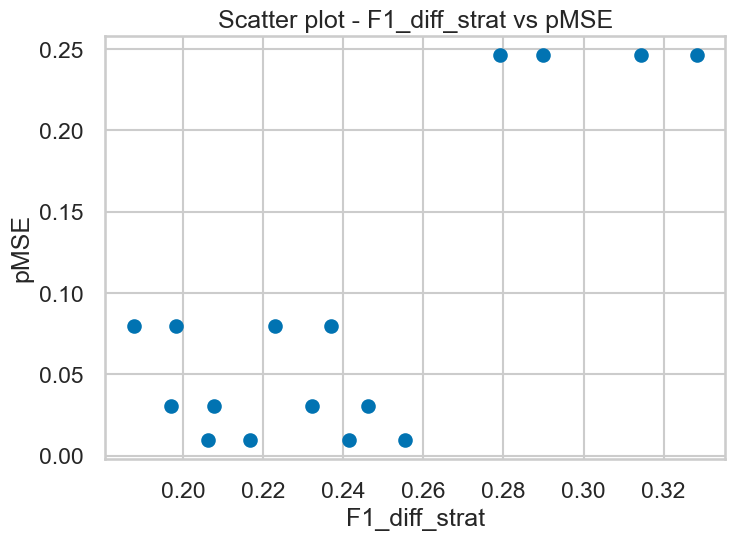

,SDG,quality,original_id,pMSE,pMSE_time,s_pMSE,s_pMSE_time,Cluster_G_0.5,Cluster_G_0.5_time,Cluster_G_1,Cluster_G_1_time,Cluster_G_1.5,Cluster_G_1.5_time,Cluster_G_2,Cluster_G_2_time,Cluster_G_2.5,Cluster_G_2.5_time,BNLogLikelihood,BNLogLikelihood_time,GMLogLikelihood,GMLogLikelihood_time,ContinousKLDivergence,ContinousKLDivergence_time,DiscreteKLDivergence,DiscreteKLDivergence_time,KSComplement,KSComplement_time,CSTest,CSTest_time,Accuracy_original,F1_original,Kappa_original,MCC_original,model,Tuned on,F1_same,F1_strat,Kappa_same,Kappa_strat,Accuracy_same,Accuracy_strat,MCC_same,MCC_strat,Accuracy_diff_same,Accuracy_diff_strat,F1_diff_same,F1_diff_strat,MCC_diff_same,MCC_diff_strat,Kappa_diff_same,Kappa_diff_strat
0,SD0Q0,Q0,D0,0.246433,0.031248,145.250798,0.039640,95.725989,9.585969,47.901787,18.695610,31.953048,24.851620,25.551979,28.166933,20.195175,37.440654,-0.741723,0.053262,-26.982375,2.779310,0.201784,0.146535,NaN,0.000651,0.204378,0.009271,0.749553,0.001261,0.766234,0.713636,0.438866,0.461883,knn,synthetic,0.411049,0.399214,0.011610,-0.010842,0.522727,0.511039,0.009966,-0.015352,0.243506,0.255195,0.302588,0.314422,0.451917,0.477235,0.427256,0.449709
5,SD0Q0,Q0,D0,0.246433,0.031248,145.250798,0.039640,95.725989,9.585969,47.901787,18.695610,31.953048,24.851620,25.551979,28.166933,20.195175,37.440654,-0.741723,0.053262,-26.982375,2.779310,0.201784,0.146535,NaN,0.000651,0.204378,0.009271,0.749553,0.001261,0.746753,0.678394,0.377617,0.411811,knn,synthetic,0.411049,0.399214,0.011610,-0.010842,0.522727,0.511039,0.009966,-0.015352,0.224026,0.235714,0.267345,0.279179,0.401844,0.427162,0.366006,0.388459
10,SD0Q0,Q0,D0,0.246433,0.031248,145.250798,0.039640,95.725989,9.585969,47.901787,18.695610,31.953048,24.851620,25.551979,28.166933,20.195175,37.440654,-0.741723,0.053262,-26.982375,2.779310,0.201784,0.146535,NaN,0.000651,0.204378,0.009271,0.749553,0.001261,0.753247,0.688988,0.396452,0.428830,knn,synthetic,0.411049,0.399214,0.011610,-0.010842,0.522727,0.511039,0.009966,-0.015352,0.230519,0.242208,0.277940,0.289774,0.418863,0.444182,0.384842,0.407294
15,SD0Q0,Q0,D0,0.246433,0.031248,145.250798,0.039640,95.725989,9.585969,47.901787,18.695610,31.953048,24.851620,25.551979,28.166933,20.195175,37.440654,-0.741723,0.053262,-26.982375,2.779310,0.201784,0.146535,NaN,0.000651,0.204378,0.009271,0.749553,0.001261,0.766234,0.727594,0.459016,0.466667,knn,synthetic,0.411049,0.399214,0.011610,-0.010842,0.522727,0.511039,0.009966,-0.015352,0.243506,0.255195,0.316546,0.328380,0.456700,0.482018,0.447406,0.469859
20,SD0Q1,Q1,D0,0.079498,0.029750,46.621259,0.039680,53.801844,18.530327,27.595937,24.270946,18.768747,29.015979,16.274559,33.596264,13.514147,37.669718,-0.744809,0.054194,-38.759563,1.942152,0.212973,0.147797,NaN,0.000657,0.649902,0.008973,0.741726,0.001243,0.766234,0.713636,0.438866,0.461883,knn,synthetic,0.559687,0.490690,0.149805,0.013631,0.596104,0.535065,0.155574,0.014584,0.170130,0.231169,0.153949,0.222946,0.306310,0.447299,0.289062,0.425235
25,SD0Q1,Q1,D0,0.079498,0.029750,46.621259,0.039680,53.801844,18.530327,27.595937,24.270946,18.768747,29.015979,16.274559,33.596264,13.514147,37.669718,-0.744809,0.054194,-38.759563,1.942152,0.212973,0.147797,NaN,0.000657,0.649902,0.008973,0.741726,0.001243,0.746753,0.678394,0.377617,0.411811,knn,synthetic,0.559687,0.490690,0.149805,0.013631,0.596104,0.535065,0.155574,0.014584,0.150649,0.211688,0.118707,0.187703,0.256237,0.397226,0.227812,0.363985
30,SD0Q1,Q1,D0,0.079498,0.029750,46.621259,0.039680,53.801844,18.530327,27.595937,24.270946,18.768747,29.015979,16.274559,33.596264,13.514147,37.669718,-0.744809,0.054194,-38.759563,1.942152,0.212973,0.147797,NaN,0.000657,0.649902,0.008973,0.741726,0.001243,0.753247,0.688988,0.396452,0.428830,knn,synthetic,0.559687,0.490690,0.149805,0.013631,0.596104,0.535065,0.155574,0.014584,0.157143,0.218182,0.129301,0.198298,0.273256,0.414246,0.246647,0.382821
35,SD0Q1,Q1,D0,0.079498,0.029750,46.621259,0.039680,53.801844,18.530327,27.595937,24.270946,18.768747,29.

In [62]:
data = combined_data[(combined_data['original_id']=='D0') & (combined_data['model']=='knn')]

y_axis='pMSE'
x_axis='F1_diff_strat'

plt.scatter(data[x_axis], data[y_axis])
plt.title(f'Scatter plot - {x_axis} vs {y_axis}')
plt.xlabel(x_axis)
plt.ylabel(y_axis)
plt.show()

data

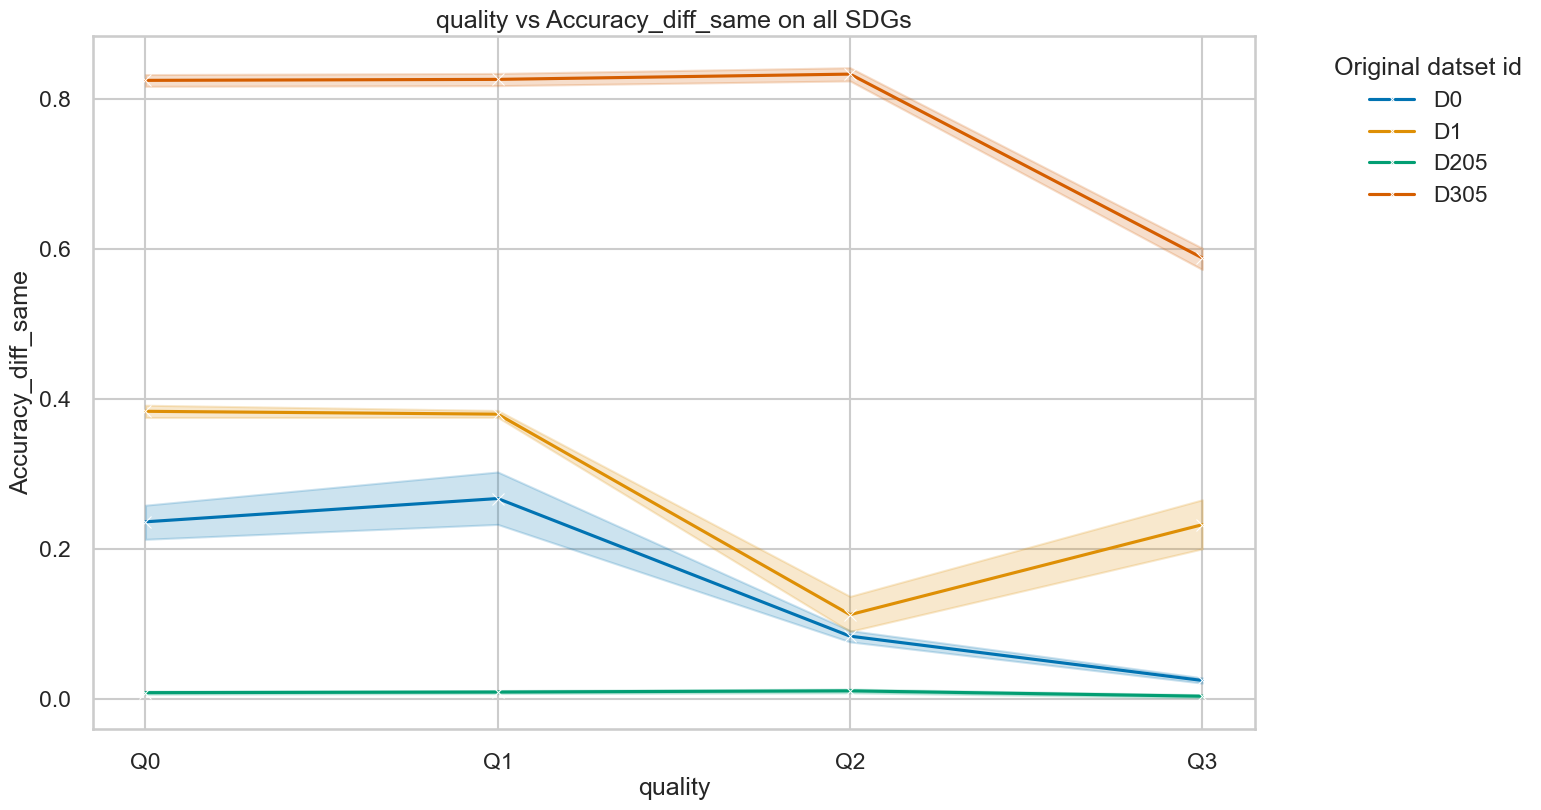

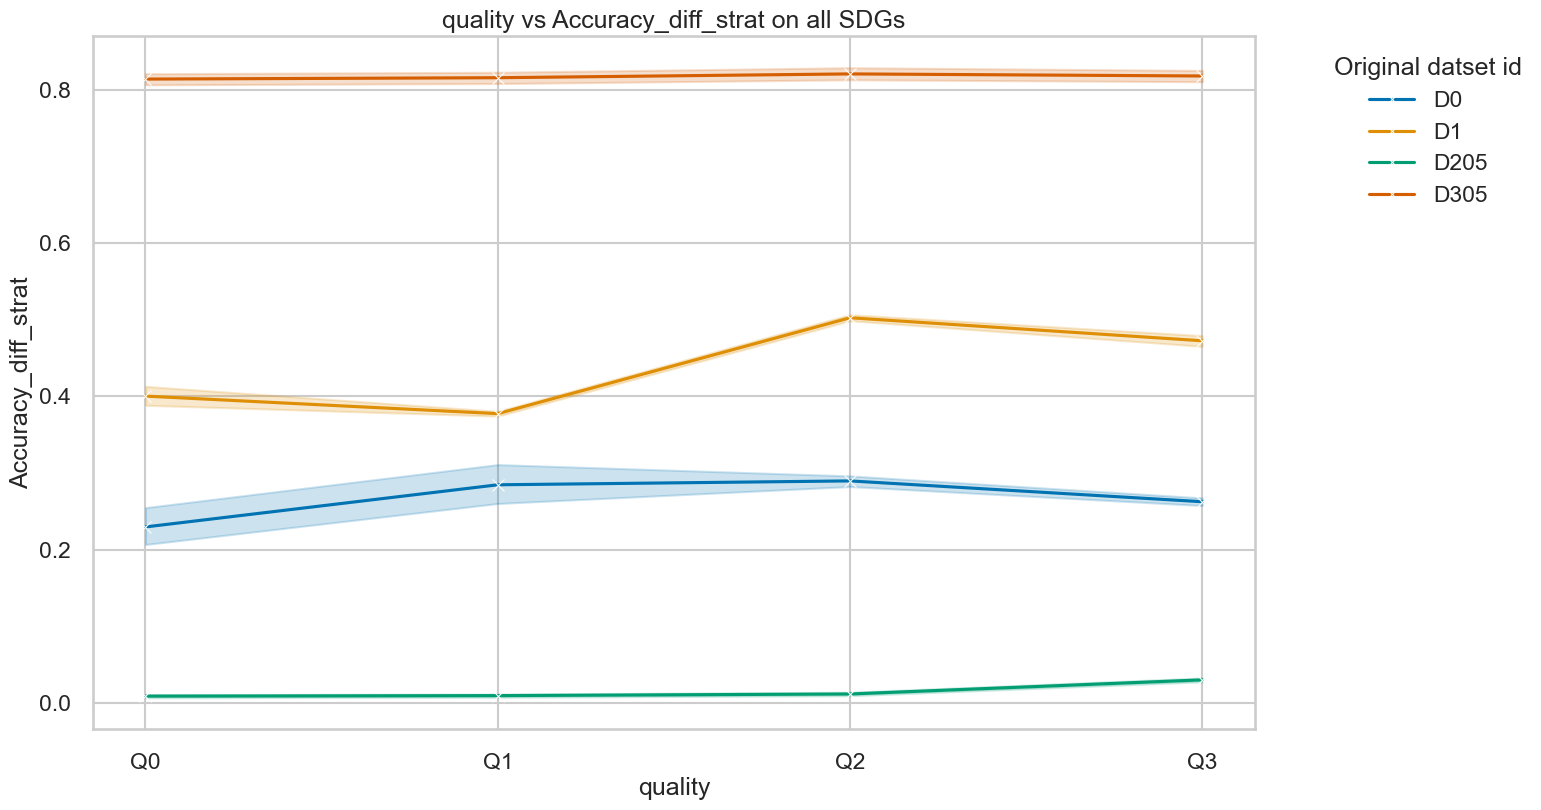

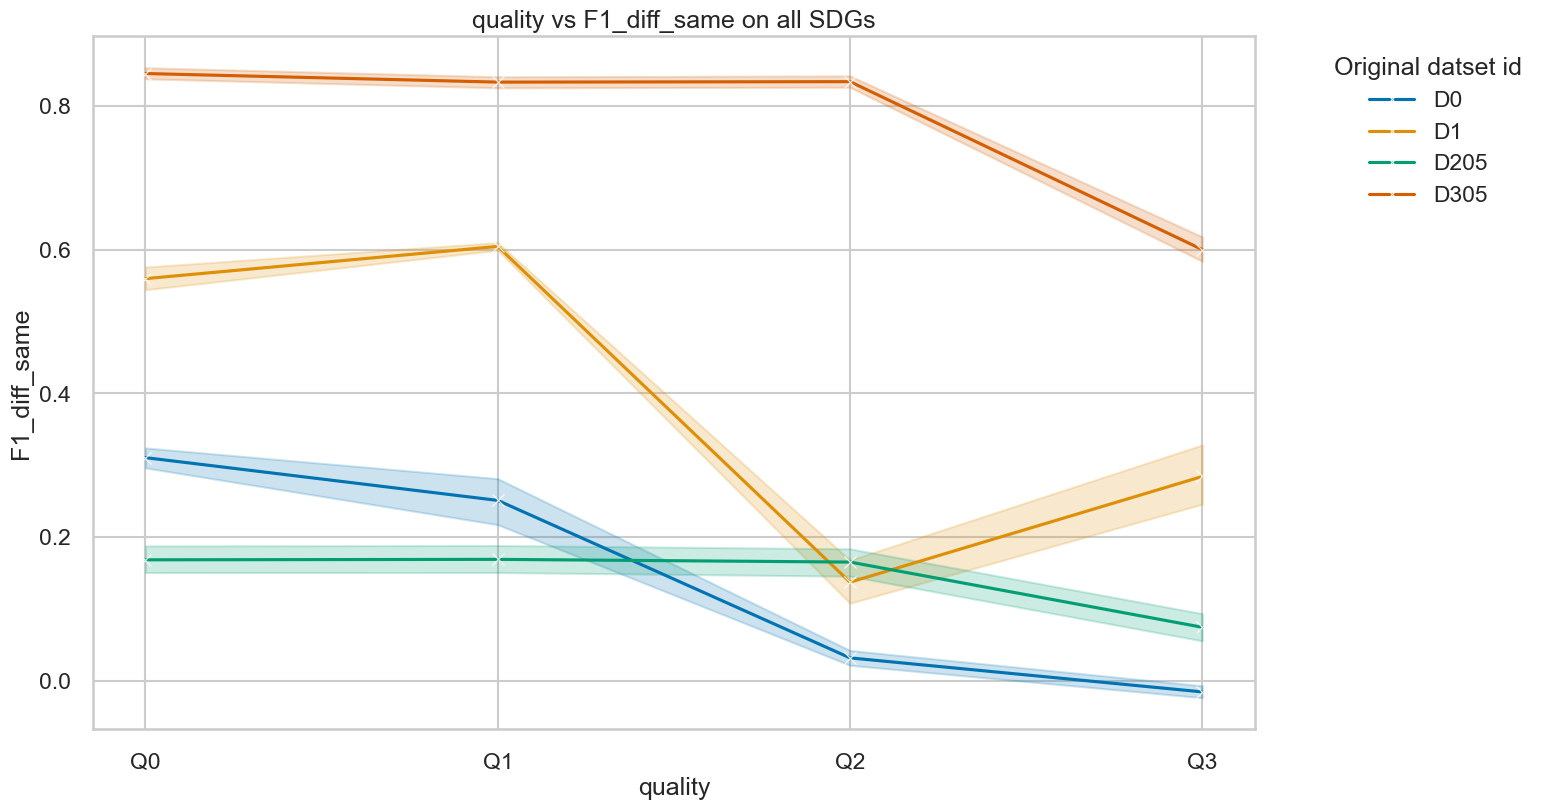

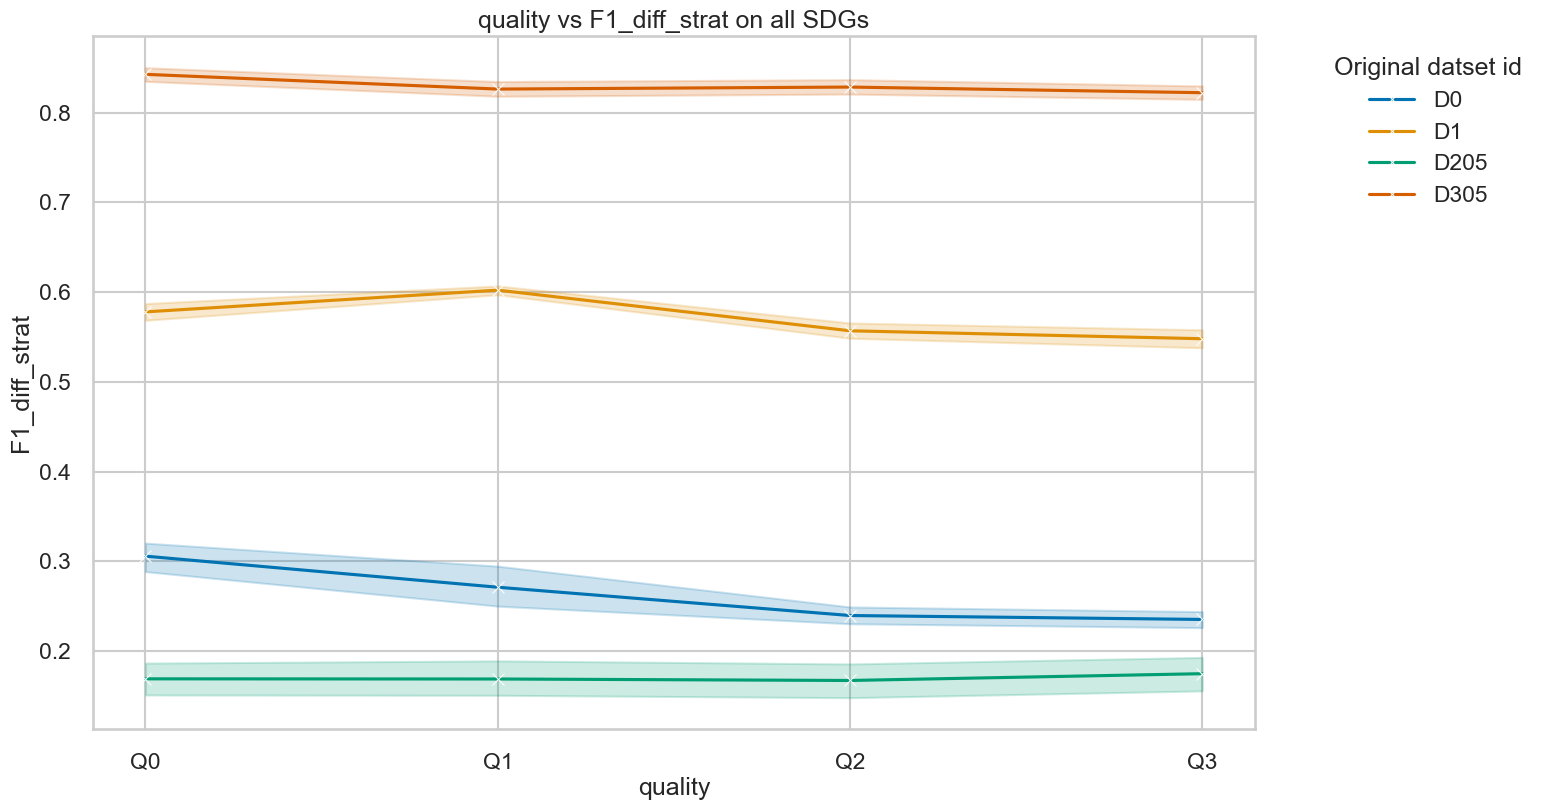

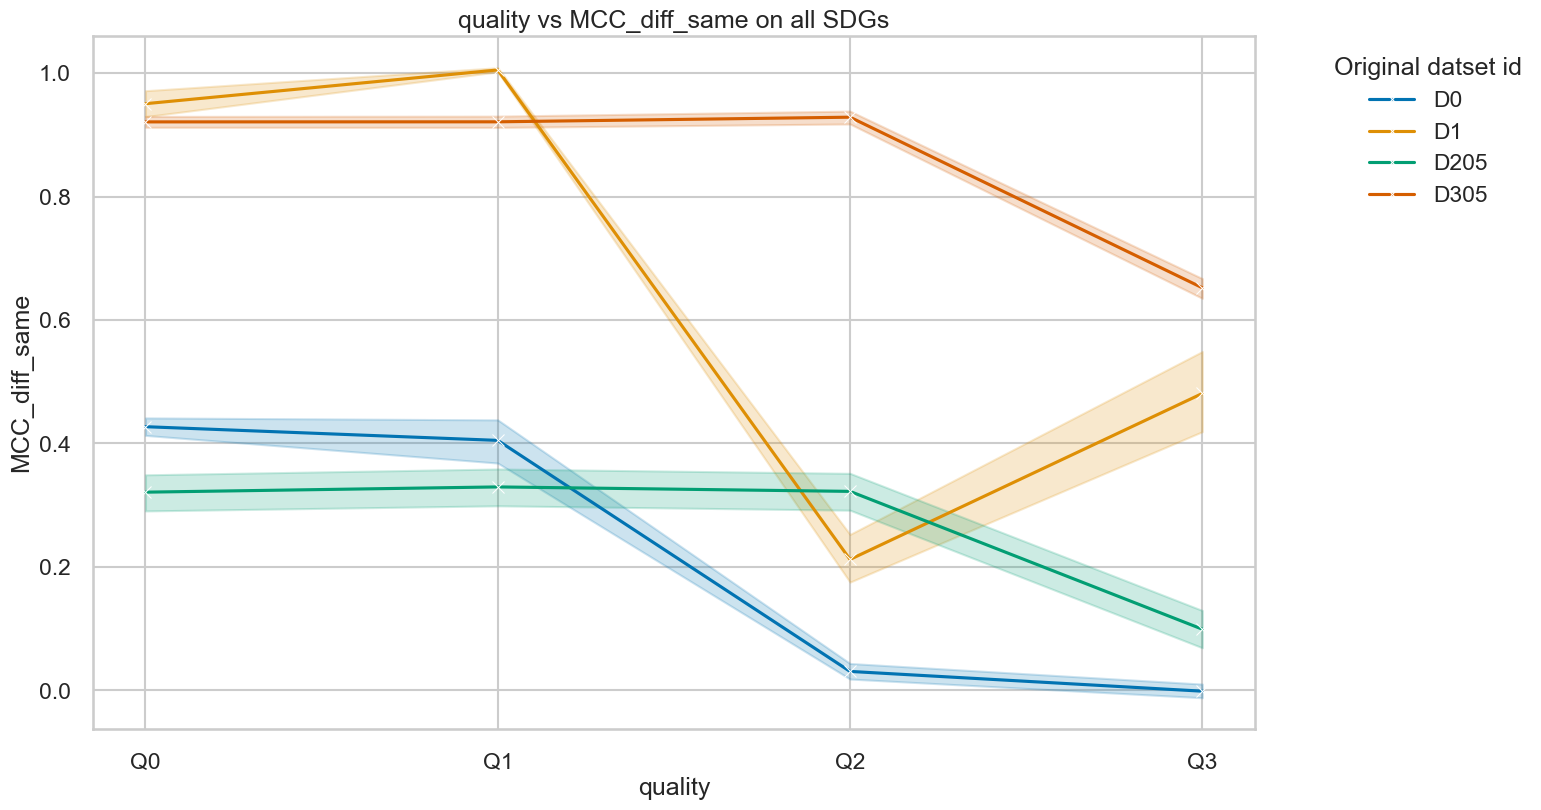

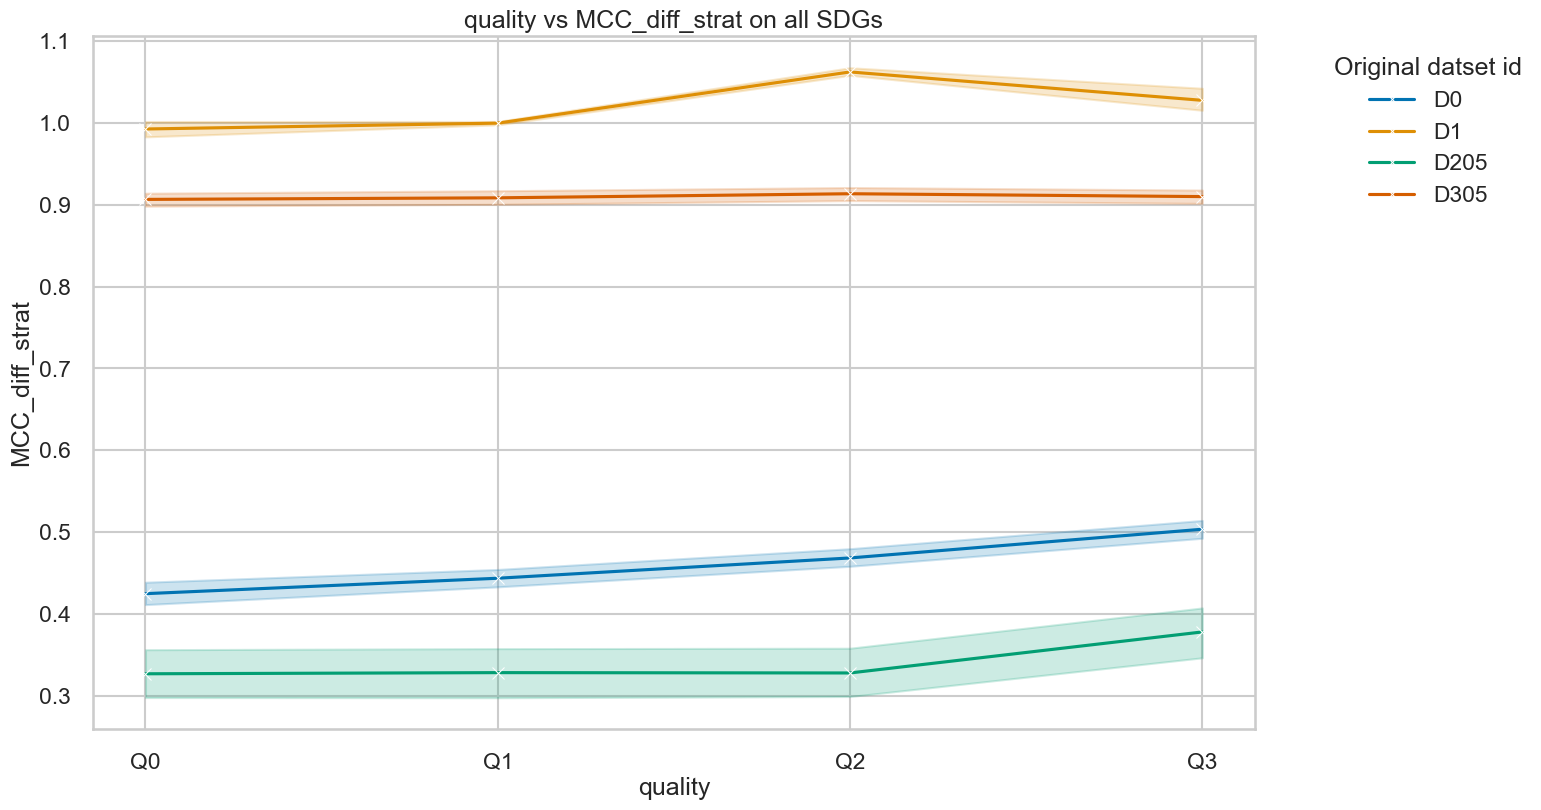

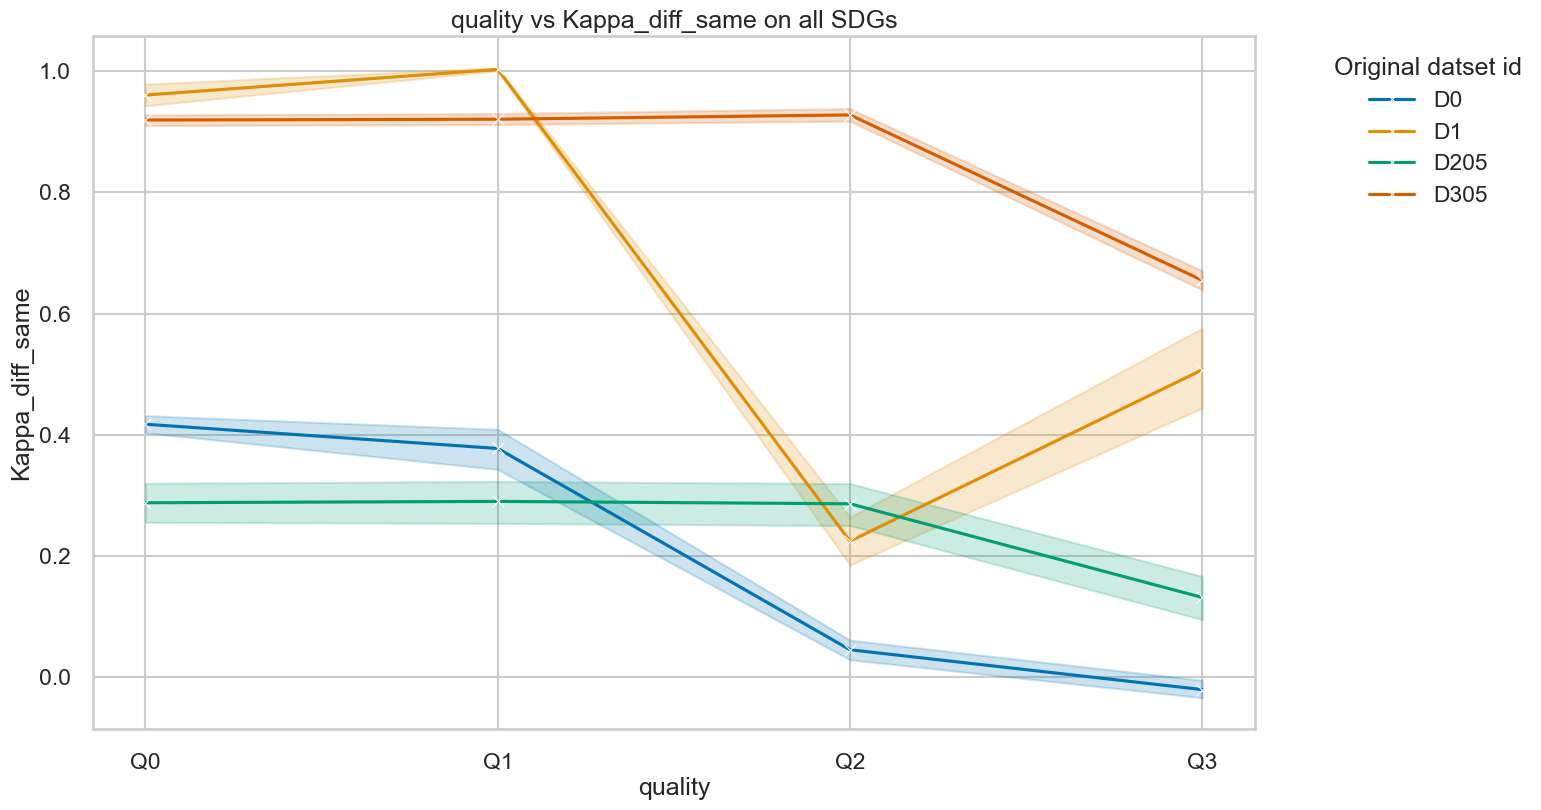

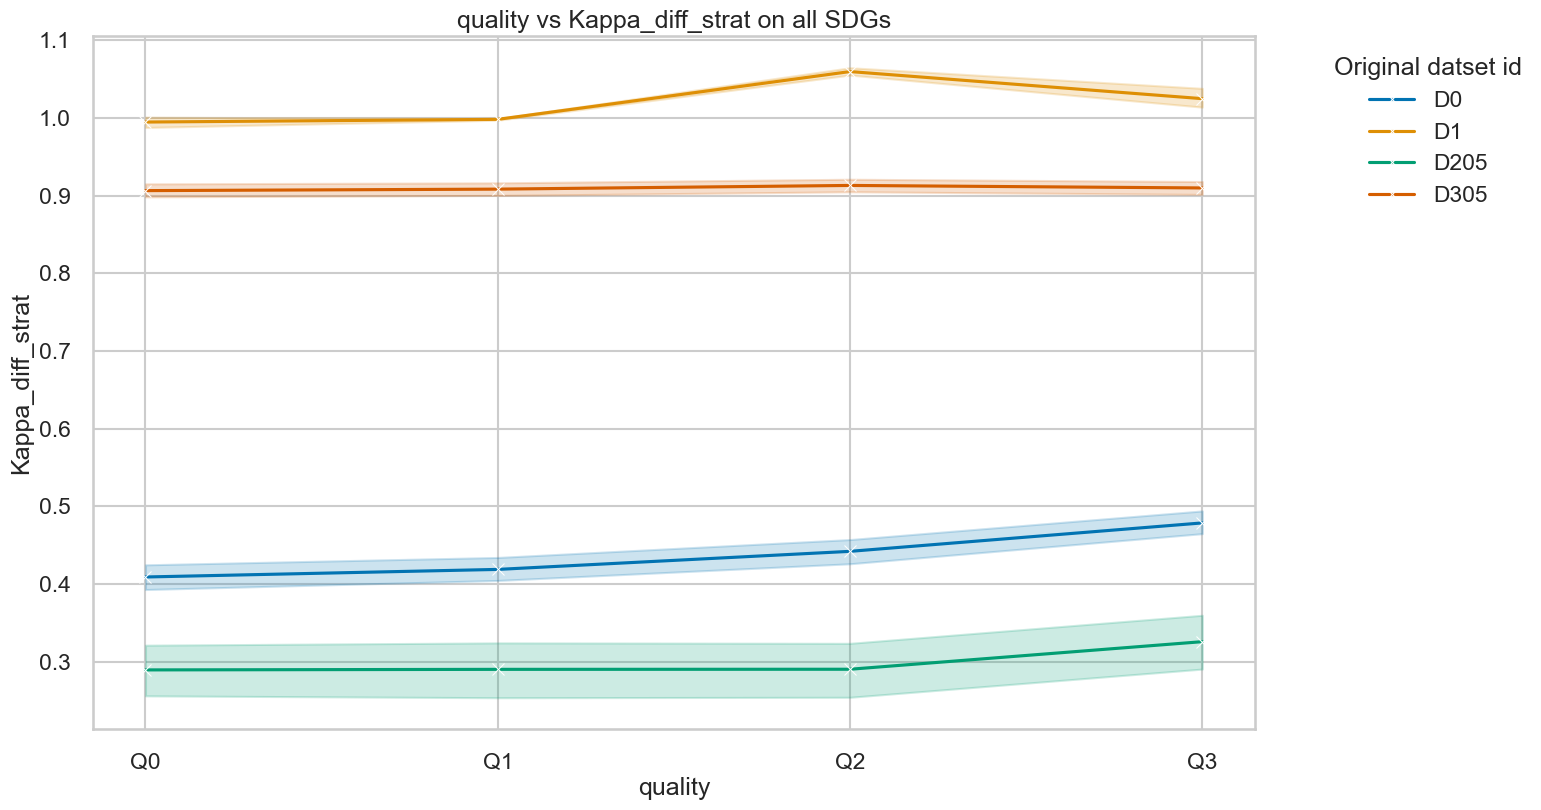

In [23]:
x_axis = 'quality'
y_axis = 'Accuracy_diff_same'

for col in perf_cols:
    y_axis=col
    # Get unique original datasets
    unique_original_datasets = combined_data['original_id'].unique()

    plt.figure(figsize=(15, 9))

    # Iterate through unique original datasets
    for data_id in unique_original_datasets:
        # Create a new dataframe with only the current original dataset
        current_data = combined_data[combined_data['original_id'] == data_id]

        sns.lineplot(
            x=x_axis,
            y=y_axis,
            data=current_data,
            marker='x',
            label=data_id,
        )

    # Add labels and title
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title(f"{x_axis} vs {y_axis} on all SDGs")

    # Add legend
    plt.legend(title='Original datset id', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Display the plot
    plt.show()


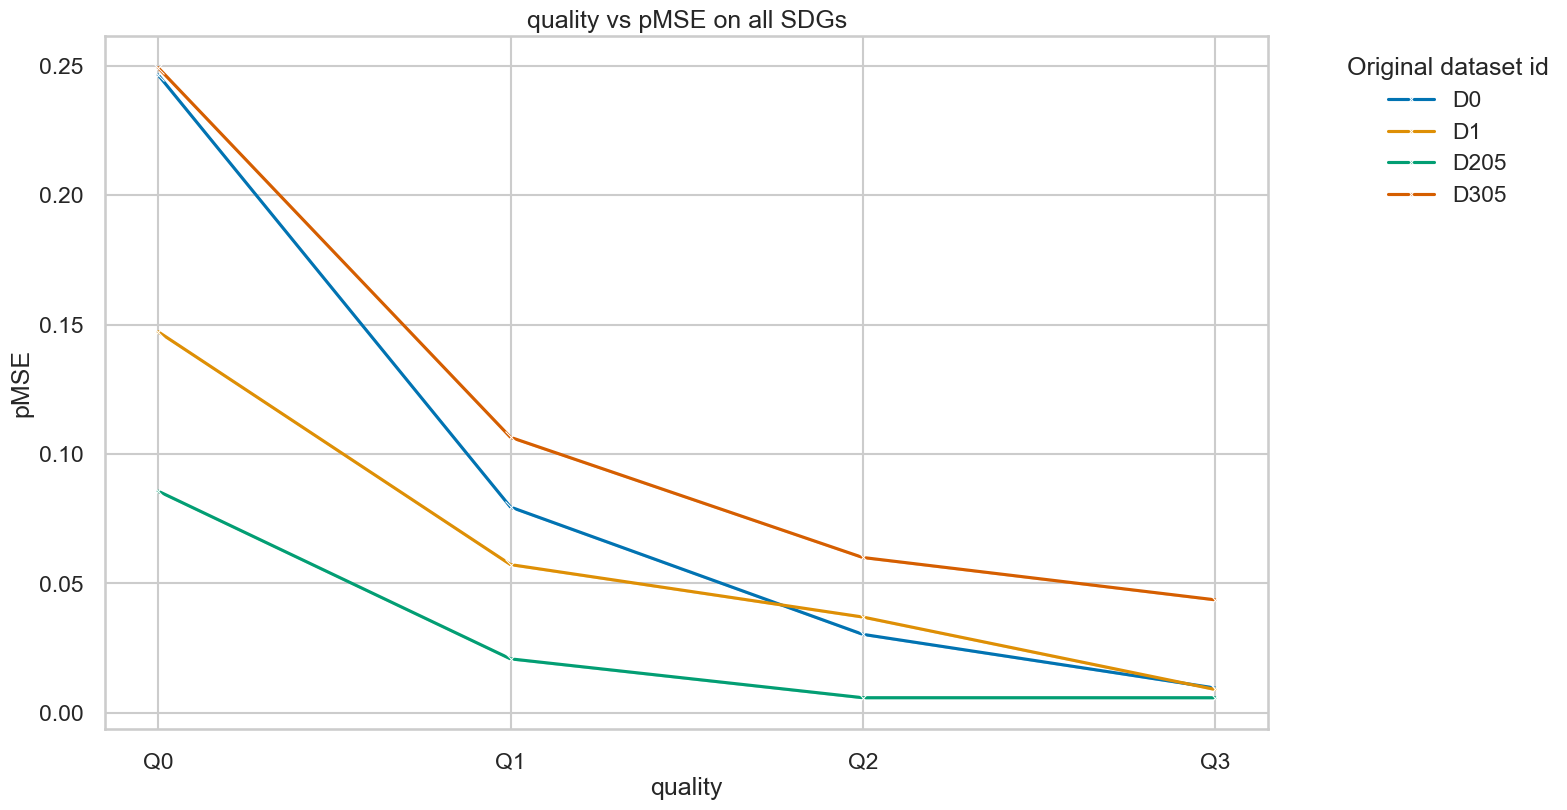

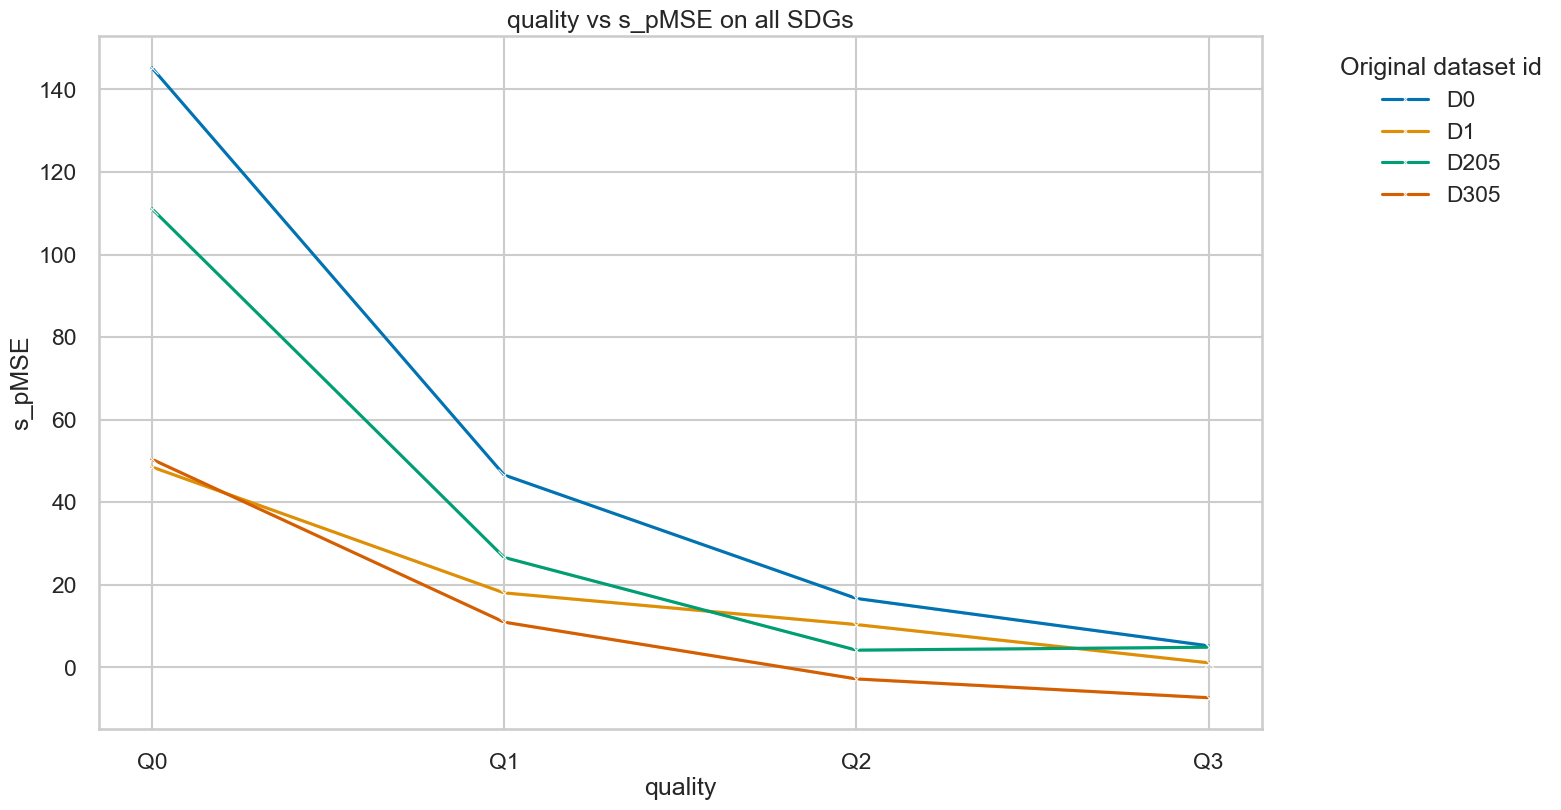

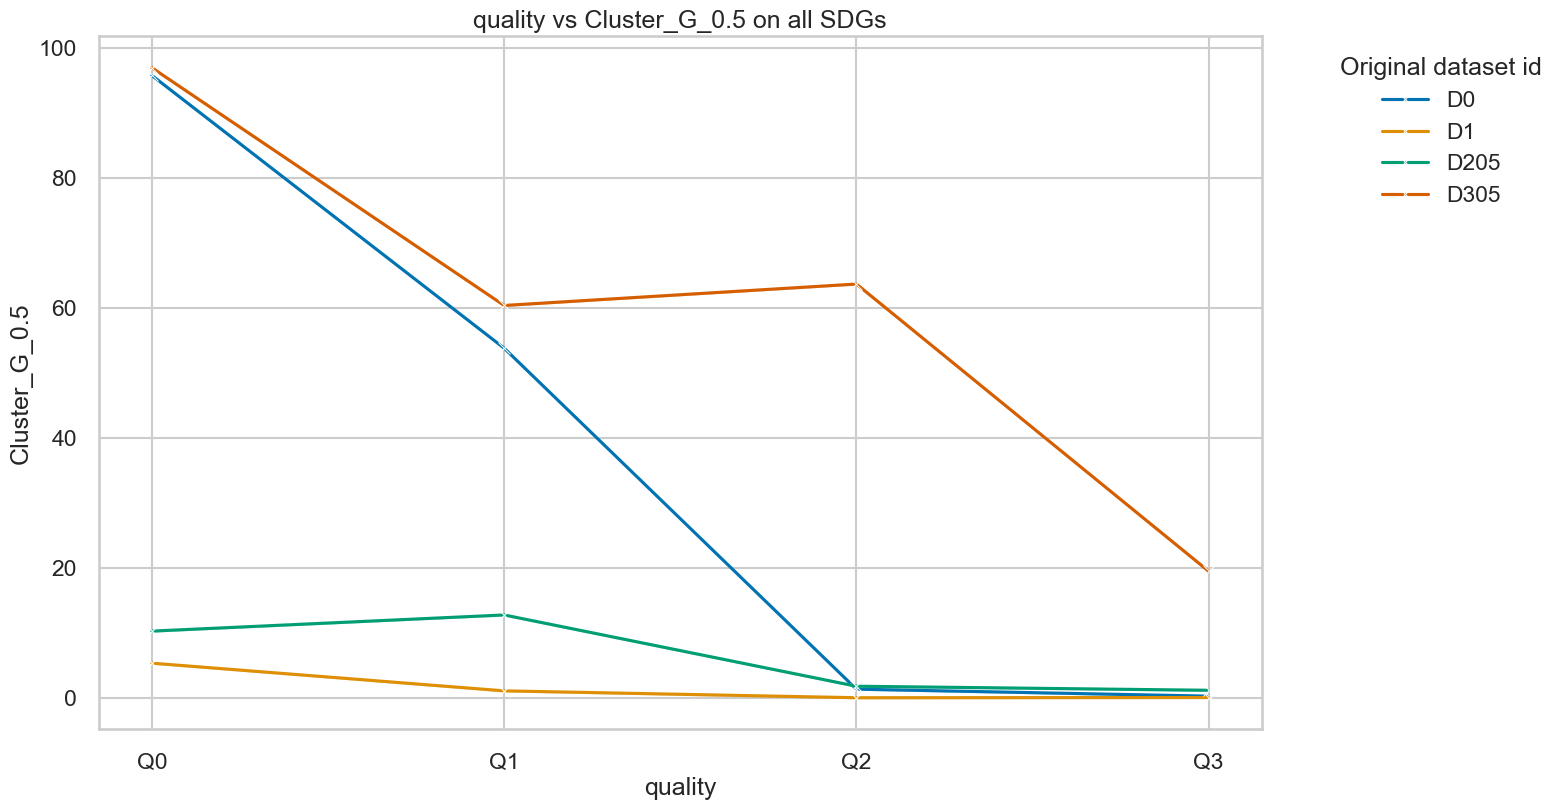

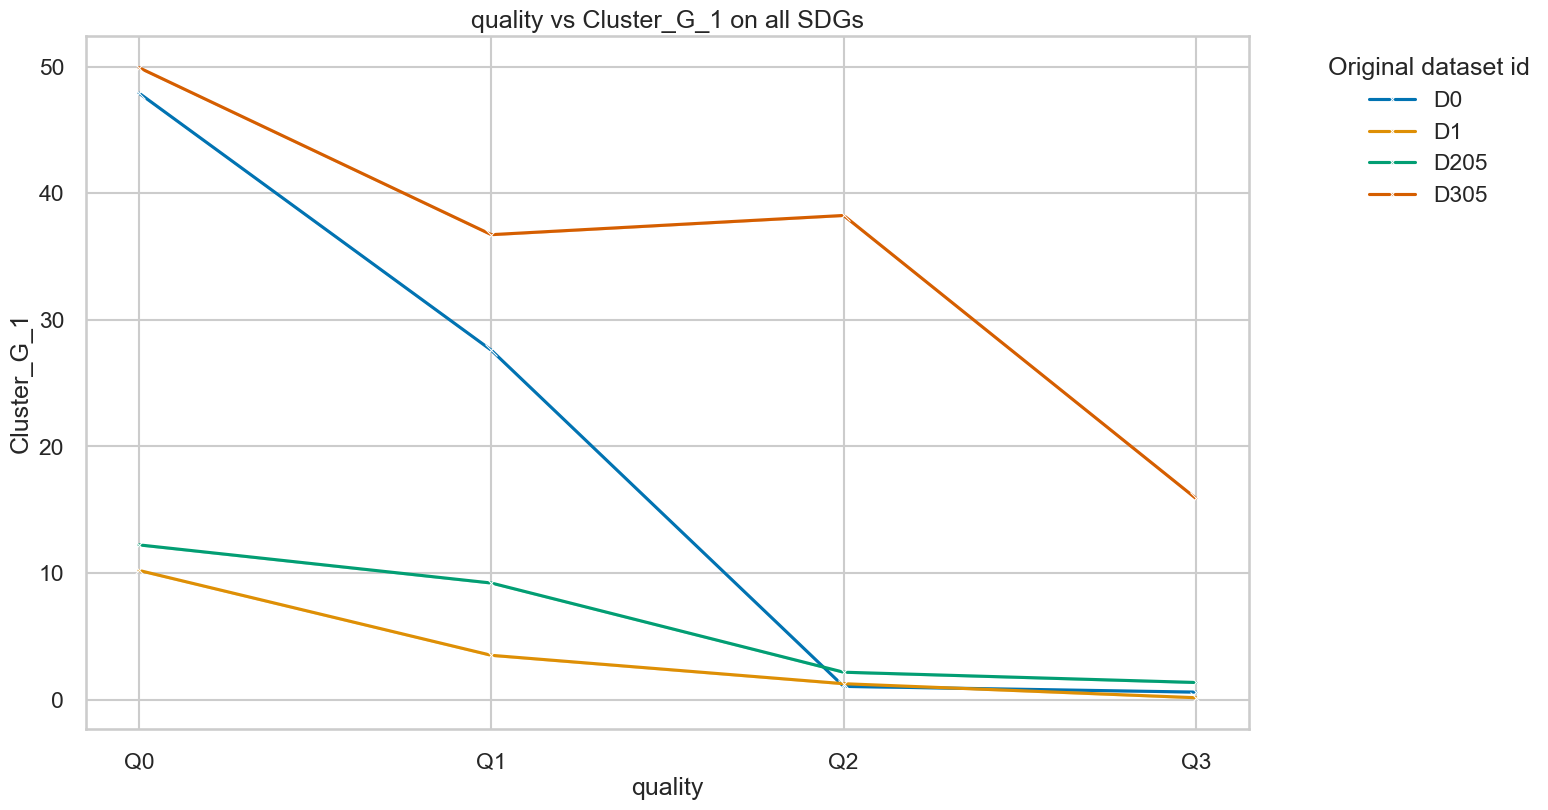

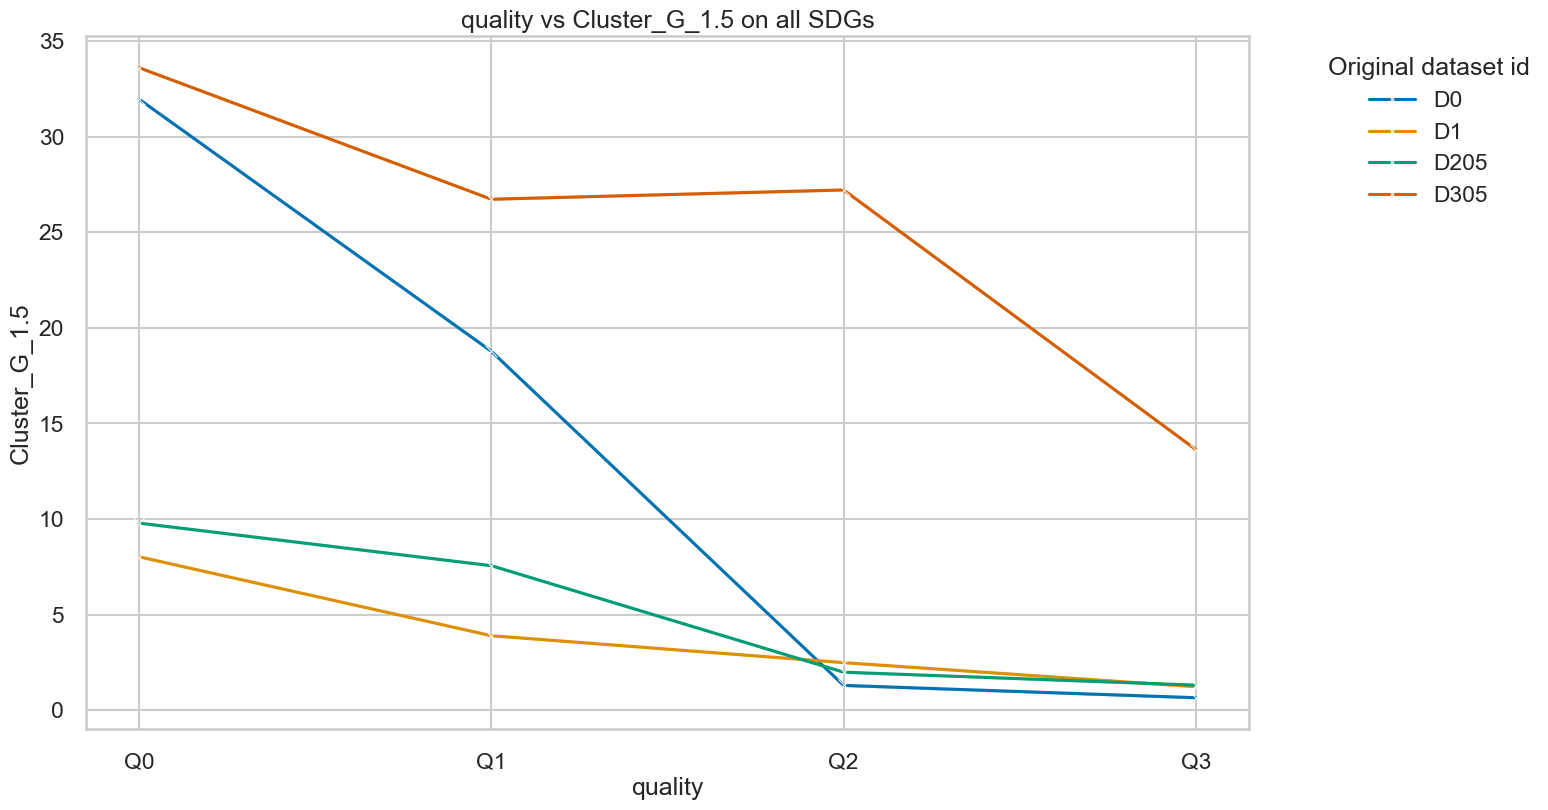

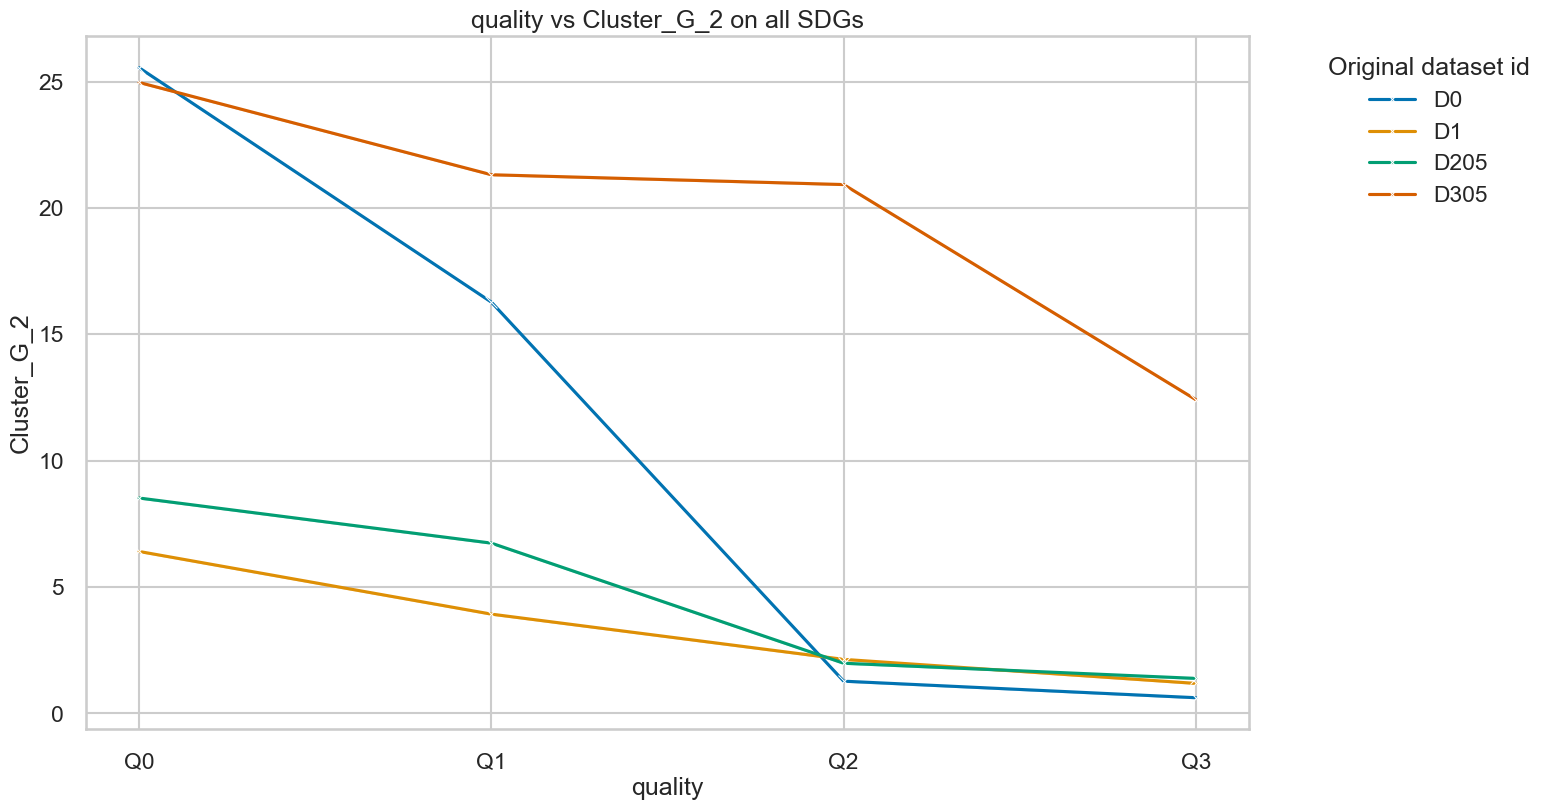

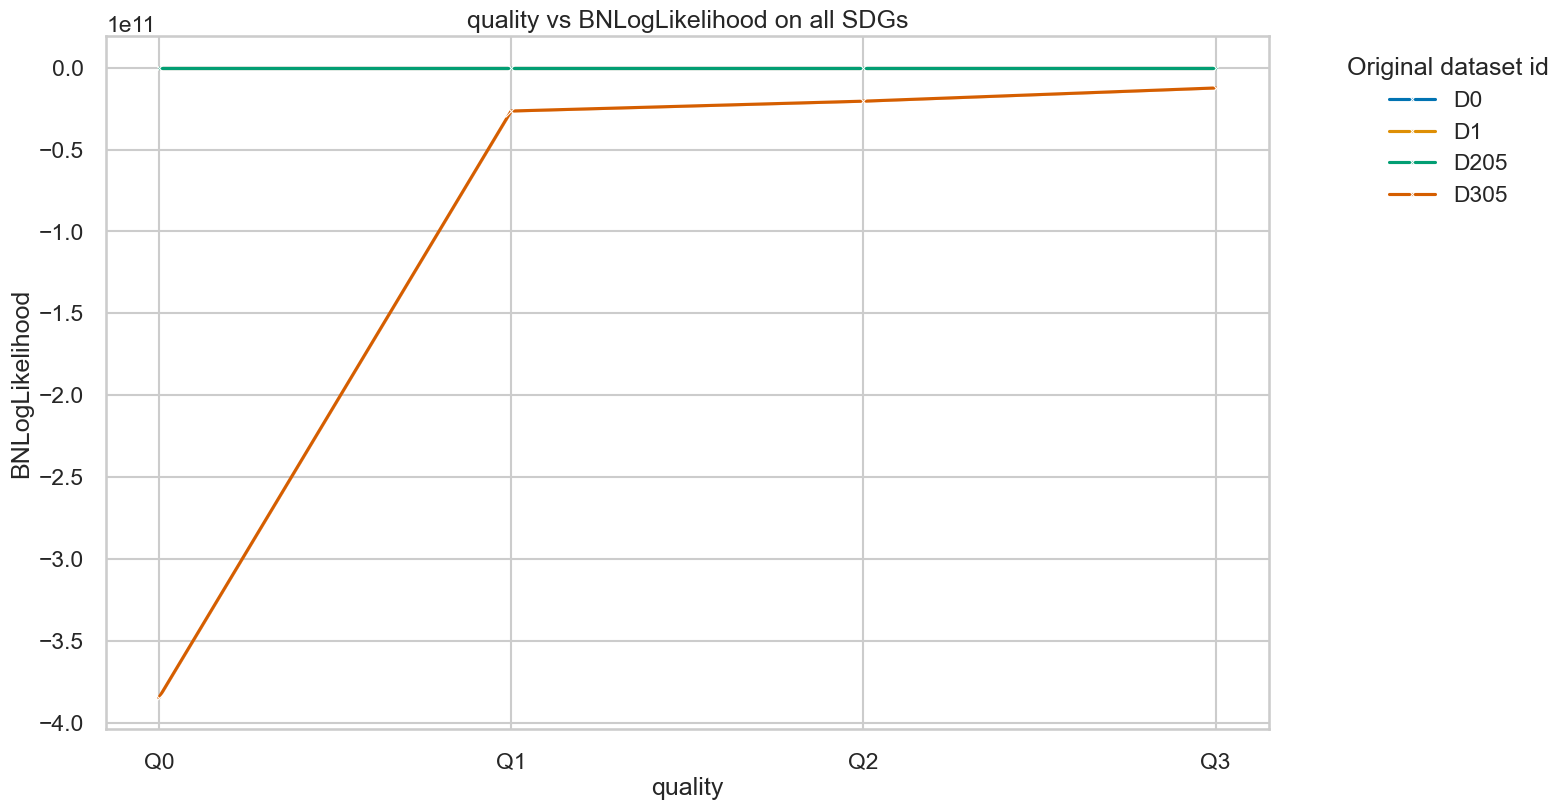

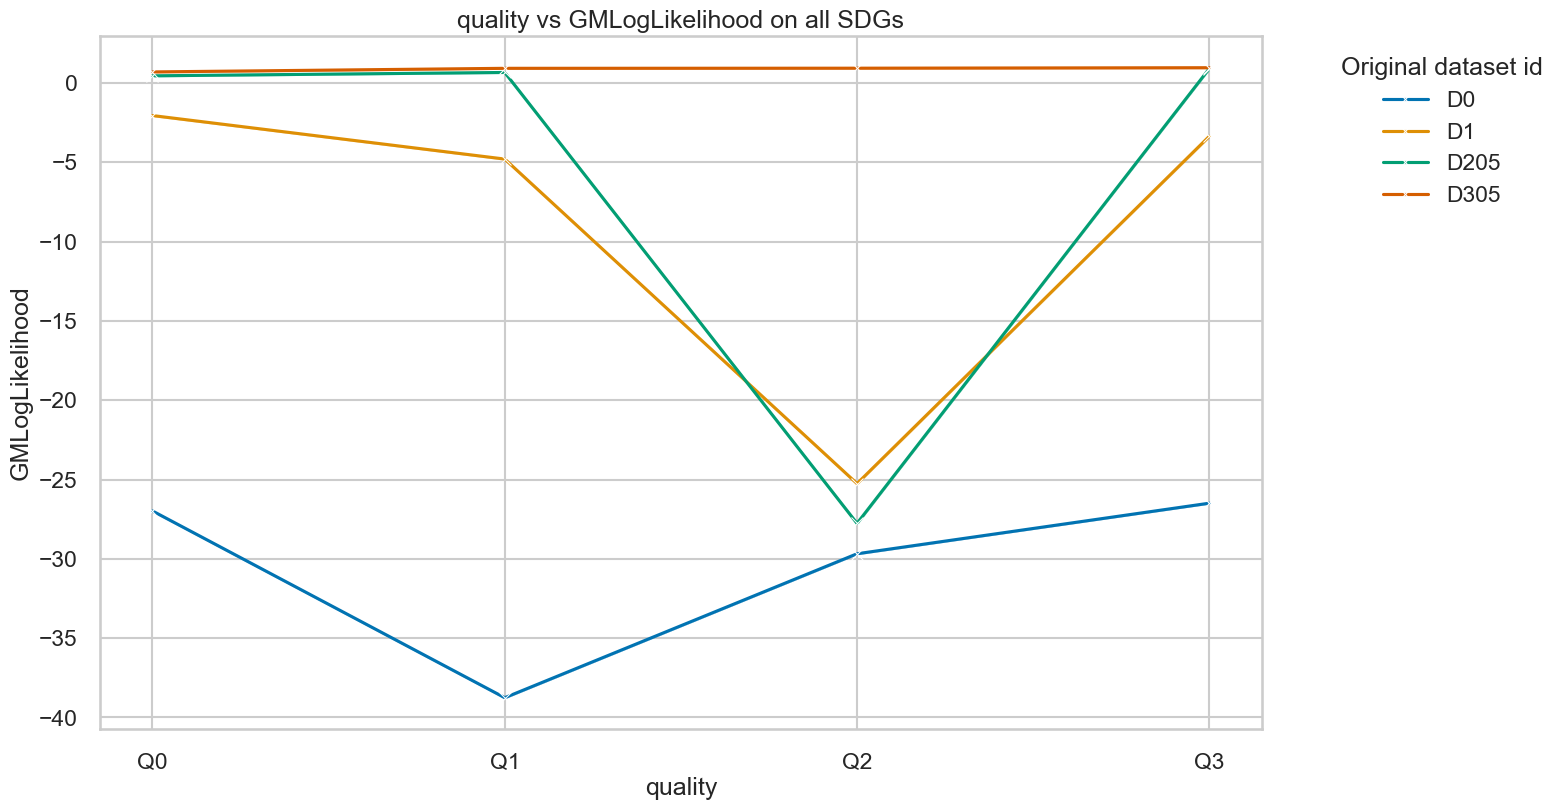

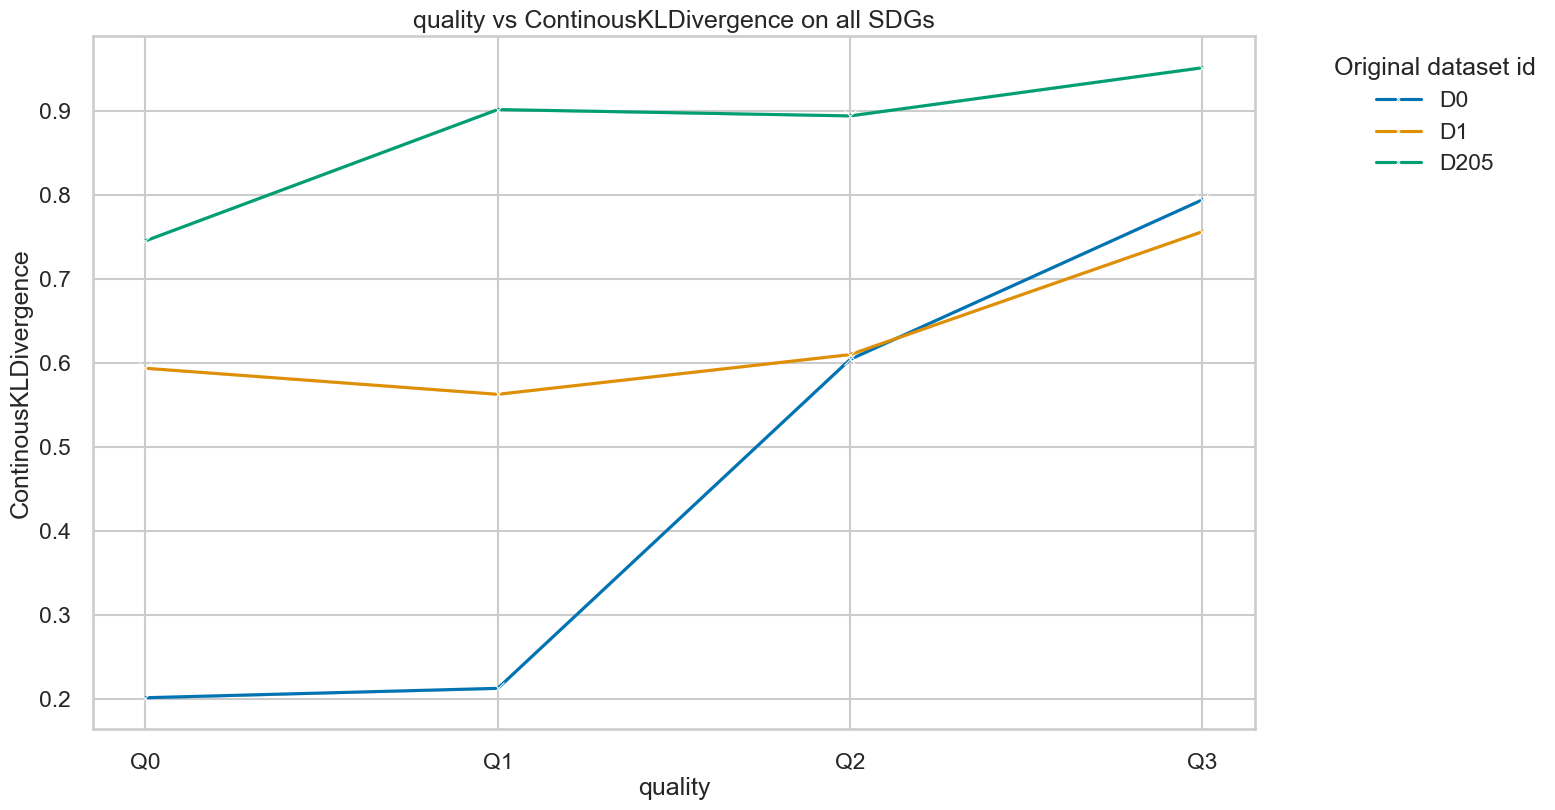

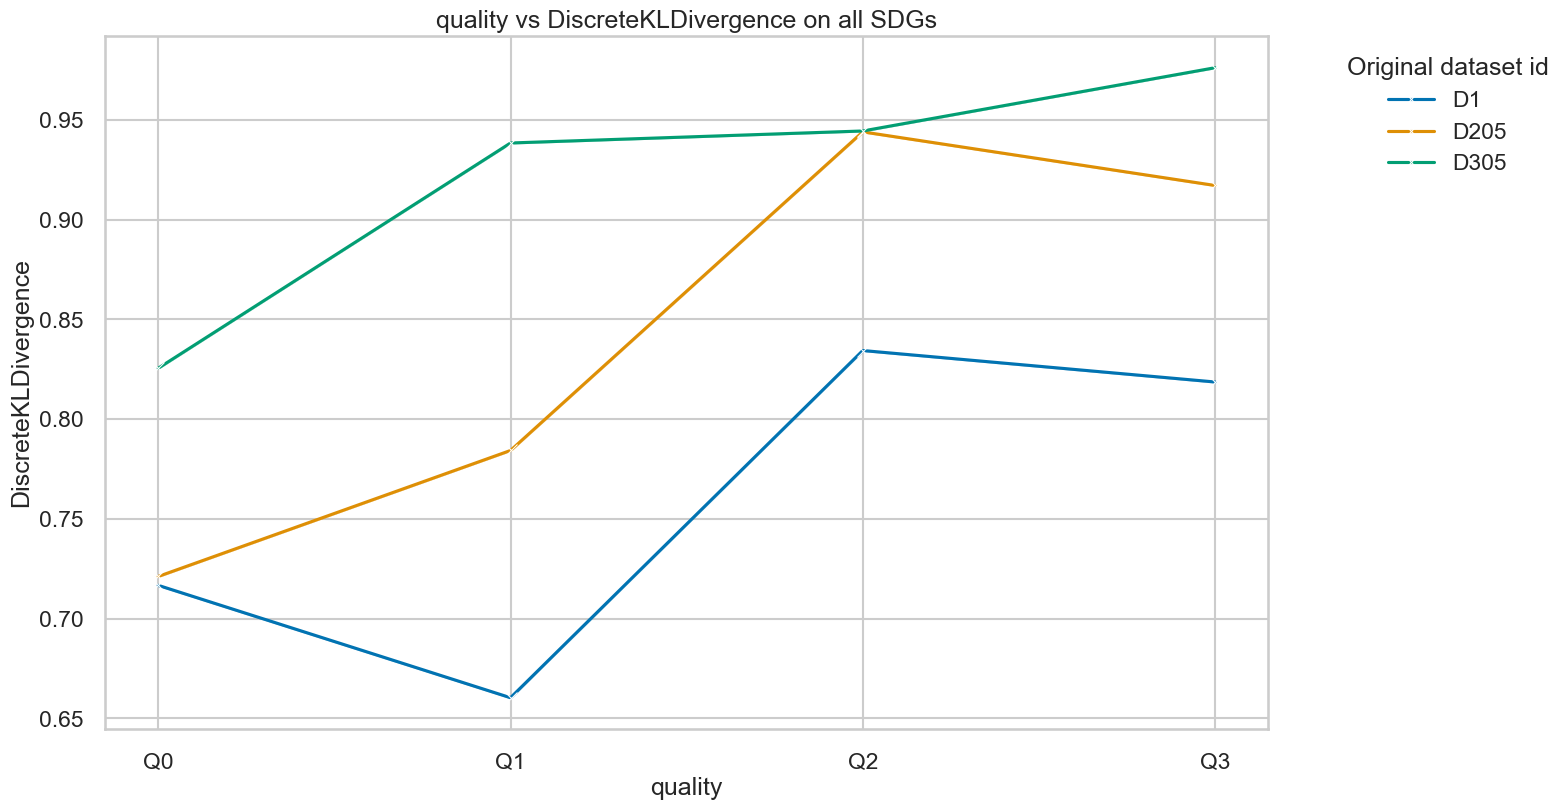

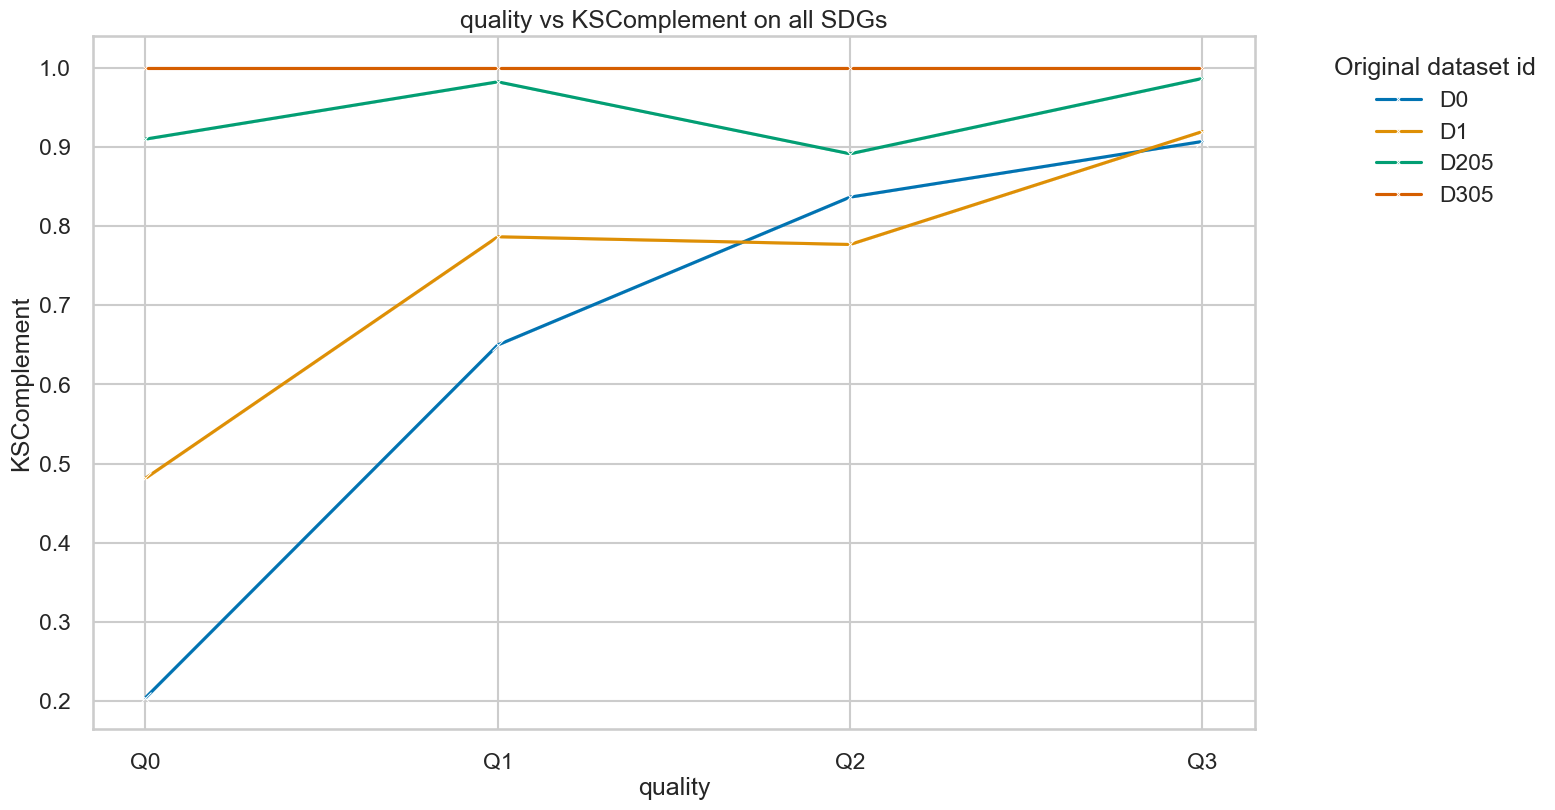

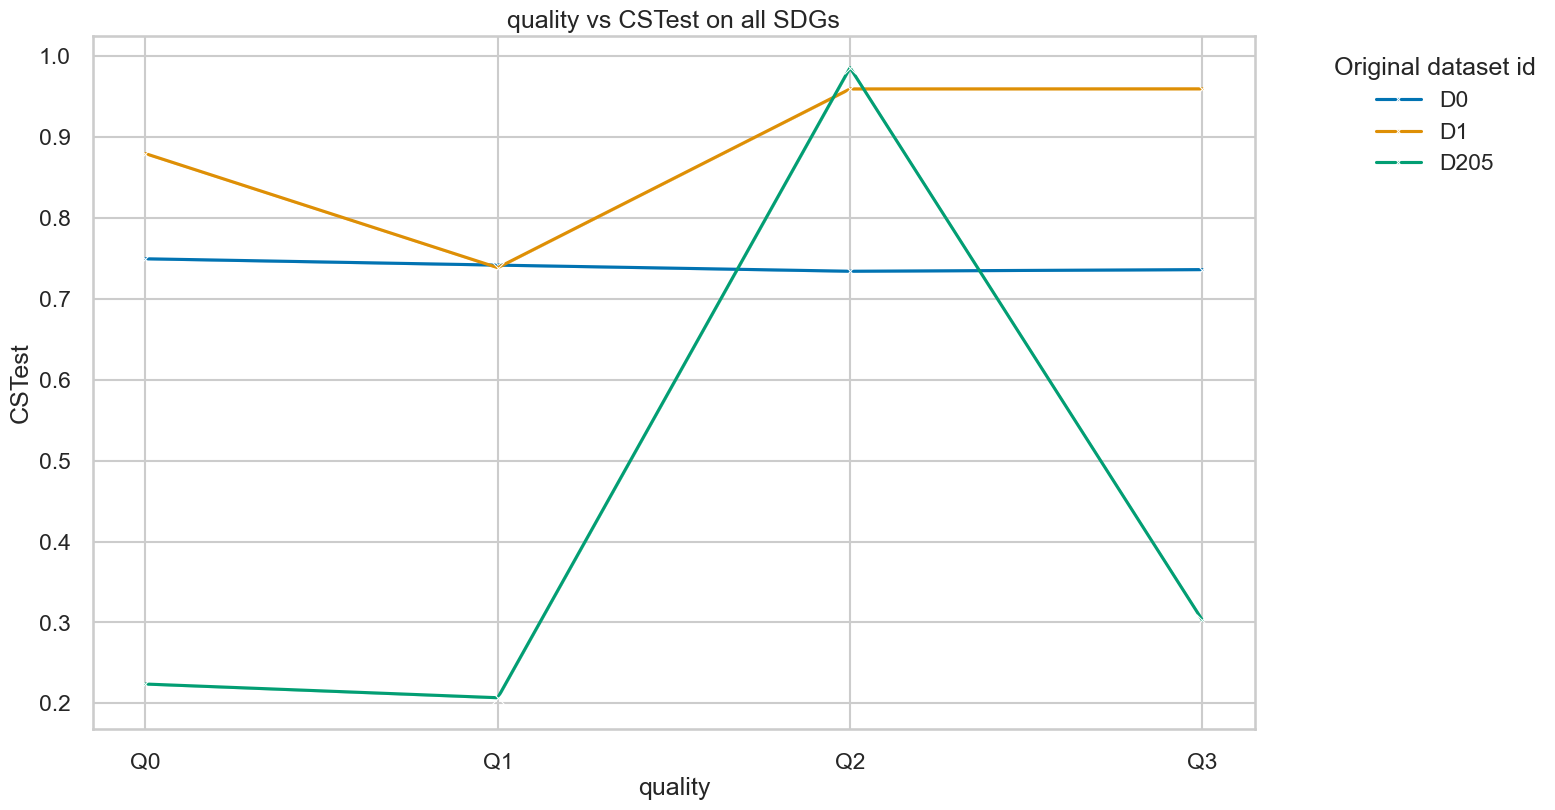

In [24]:
x_axis = 'quality'

# Get unique original datasets
unique_original_datasets = combined_data['original_id'].unique()

for col in pf_columns:
    y_axis = col
    plt.figure(figsize=(15, 9))

    # Iterate through unique original datasets
    for data_id in unique_original_datasets:
        # Create a new dataframe with only the current original dataset
        current_data = combined_data[combined_data['original_id'] == data_id]
        # skip if there is any null values
        if current_data[col].isna().any():
            continue

        sns.lineplot(
            x=x_axis,
            y=y_axis,
            data=current_data,
            marker='x',
            label=data_id,
        )

    # Add labels and title
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title(f"{x_axis} vs {y_axis} on all SDGs")

    # Add legend
    plt.legend(title='Original dataset id', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Display the plot
    plt.show()

KeyError: 'Quality'

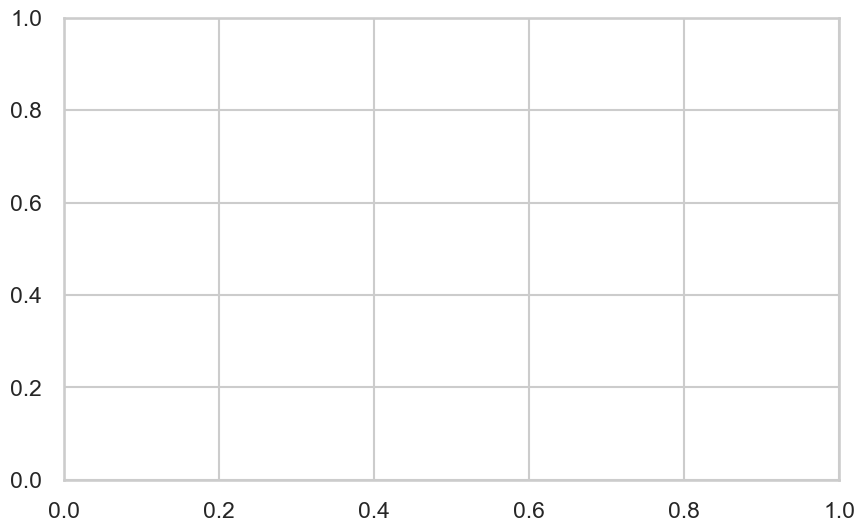

In [25]:
###### Barplot for the difference of performance over all SDG
# Set up the plot
bar_width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))


# Create an index for the SDGs
index = np.arange(len(combined_data['Quality']))

# Create the bars for F1_diff and Accuracy_diff
f1_diff_bars = ax.bar(index, combined_data['F1_diff_same'], bar_width, label='F1 difference (same)')
accuracy_diff_bars = ax.bar(index + bar_width, combined_data['Accuracy_diff_same'], bar_width, label='Accuracy difference (same)')

# Set up the x-axis labels and title
ax.set_xlabel('SDG')
ax.set_ylabel('Performance')
ax.set_title('F1_diff and Accuracy_diff for each SDG')

# Set the ticks and labels on the x-axis
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(combined_data['SDG'])

# Add the legend
ax.legend()

# Display the plot
plt.show()


In [ ]:
x_axis
y_axis
# Set up the plot
bar_width = 0.1
fig, ax = plt.subplots(figsize=(20, 6))

# Create an index for the SDGs
index = np.arange(len(combined_data['Quality']))

# Create bars for each column
for i, col in enumerate(pf_columns):
    ax.bar(index + i * bar_width, combined_data[col], bar_width, label=col)

# Set up the x-axis labels and title
ax.set_xlabel('Quality')
ax.set_ylabel('Performance')
ax.set_title('Performance Metrics for each SDG')

# Set the ticks and labels on the x-axis
ax.set_xticks(index + len(pf_columns) * bar_width / 2)
ax.set_xticklabels(combined_data['SDG'])

# Add the legend
ax.legend()

# Display the plot
plt.show()


In [ ]:
# Provided DataFrame
data = pf_df[pf_df['SDG']=='SD305Q3']


# Calculate the mean of the columns
mean_times = data[time_columns].mean()

# Prepare the data for the bar plot
bar_data = pd.DataFrame({'measure': [col[:-5] for col in time_columns], 'mean_time': mean_times.values})

# Create a bar plot
plt.figure(figsize=(10, 5))
plt.bar(bar_data['measure'], bar_data['mean_time'])
plt.xlabel('Measure')
plt.ylabel('Average Time')
plt.title('Average Time vs Measure')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Provided DataFrame
data = m_pf

# Columns with "_time" suffix
time_columns = ['pMSE_time', 's_pMSE_time', 'BNLogLikelihood_time',
                'ContinousKLDivergence_time', 'DiscreteKLDivergence_time', 'KSComplement_time', 'CSTest_time',
                'CrossClassification_time']

# Calculate the mean of the columns
mean_times = data[time_columns].mean()

# Prepare the data for the bar plot
bar_data = pd.DataFrame({'measure': [col[:-5] for col in time_columns], 'mean_time': mean_times.values})

# Create a bar plot
plt.figure(figsize=(10, 5))
plt.bar(bar_data['measure'], bar_data['mean_time'])
plt.xlabel('Measure')
plt.ylabel('Average Time')
plt.title('Average Time vs Measure, excl: Cluster & GMLogLikelihood')
plt.xticks(rotation=45)
plt.show()